# Generator
Build generator architecture with:
* Attention blocks
* Spectral Convolutions
* Upsampling and Downsampling layers
* Resnet blocks

In [1]:
import tensorflow as tf

def attention_block(x, filters):
    """Self-attention mechanism to capture long-range dependencies"""
    batch_size = tf.shape(x)[0]
    height = tf.shape(x)[1]
    width = tf.shape(x)[2]
    
    # Change reshape operations to use tf.shape for dynamic batch size
    f = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    g = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    h = tf.keras.layers.Conv2D(filters, 1)(x)
    
    # Reshape using tf.reshape with properly specified dimensions
    f = tf.reshape(f, [batch_size, height * width, filters // 8])
    g = tf.reshape(g, [batch_size, height * width, filters // 8])
    h = tf.reshape(h, [batch_size, height * width, filters])
    
    # Compute attention map
    s = tf.matmul(f, g, transpose_b=True)
    beta = tf.nn.softmax(s)
    
    o = tf.matmul(beta, h)
    o = tf.reshape(o, [batch_size, height, width, filters])
    
    # Gamma as learnable parameter (can be initialized to 0)
    gamma = tf.Variable(0.0, trainable=True)
    return x + gamma * o

def spectral_conv2d(filters, kernel_size, strides=1):
    return tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding='same',
        kernel_initializer='orthogonal',
        use_bias=False
    )

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(spectral_conv2d(filters, size, strides=2))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    
    result.add(tf.keras.layers.PReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer='orthogonal',
            use_bias=False
        )
    )
    
    result.add(tf.keras.layers.LayerNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.SpatialDropout2D(0.5))
    
    result.add(tf.keras.layers.PReLU())
    return result

def resnet_block(input_tensor, filters, kernel_size=3):
    def squeeze_excite_block(input_tensor, ratio=16):
        channels = input_tensor.shape[-1]
        
        se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
        se = tf.keras.layers.Reshape((1, 1, channels))(se)
        se = tf.keras.layers.Dense(channels // ratio, activation='relu')(se)
        se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
        
        return tf.keras.layers.Multiply()([input_tensor, se])
    
    x = spectral_conv2d(filters, kernel_size)(input_tensor)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    x = spectral_conv2d(filters, kernel_size)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    x = squeeze_excite_block(x)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.PReLU()(x)
    
    return x

def build_generator(input_shape=(64, 64, 3)):
    # Input: 64x64
    tf.keras.backend.set_floatx('float32')
    inputs = tf.keras.layers.Input(shape=input_shape)

    
    # Initial convolution: 64x64 -> 64x64
    x = spectral_conv2d(32, 7)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    # Downsampling path
    down_stack = [
        downsample(64, 3, apply_batchnorm=False),   # 64x64 -> 32x32
        downsample(128, 3),                         # 32x32 -> 16x16
        downsample(256, 3),                         # 16x16 -> 8x8
    ]
    
    # Using more ResNet blocks since we have a smaller architecture
    num_res_blocks = 11 # Increased from 6
    
    # Upsampling path
    up_stack = [
        upsample(128, 3, apply_dropout=True),       # 8x8 -> 16x16
        upsample(64, 3),                           # 16x16 -> 32x32
        upsample(32, 3),                           # 32x32 -> 64x64
    ]

    OUTPUT_CHANNELS = 3
    # Final output layer: 64x64 -> 128x128
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer='orthogonal',
        activation='tanh'
    )
    
    # Encoder
    x = inputs  # 64x64
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Print shapes for verification
    print(f"Bottleneck shape before ResNet blocks: {x.shape}")  # Should be (None, 8, 8, 256)
    
    # ResNet blocks at 8x8 resolution
    for _ in range(num_res_blocks):
        x = resnet_block(x, filters=256)  # Reduced from 512 due to smaller size
        if _ % 2 == 0:
            x = attention_block(x, filters=256)
    
    # Decoder
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = attention_block(x, x.shape[-1])
        x = tf.keras.layers.Concatenate()([x, skip])
    
    # Final output: 64x64 -> 128x128
    outputs = last(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

2024-11-18 16:22:44.670717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 16:22:44.670772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 16:22:44.670804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 16:22:44.677387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
generator = build_generator()
generator.summary()

2024-11-18 16:22:46.284716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 16:22:46.289382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 16:22:46.289426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 16:22:46.291817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 16:22:46.291854: I tensorflow/compile

Bottleneck shape before ResNet blocks: (None, 8, 8, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 64)           67264     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 16, 16, 128)          107008    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 8, 8, 256)            312320    ['sequential_1[0][0]']        
                                     

# Discriminator
Build discriminator architecture:

In [ ]:
# DISCRIMINATOR
import tensorflow as tf
import tensorflow_addons as tfa    
from tensorflow.keras import layers

def build_discriminator(input_shape=(64, 64, 3)):
    """
    Stabilized PatchGAN discriminator with spectral normalization and smooth activation
    """
    def conv_block(x, filters, kernel_size=4, strides=2):
        # Add spectral normalization
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size, strides, padding='same',
                         kernel_initializer='orthogonal', use_bias=False))(x)
        
        # Use GroupNormalization instead of BatchNorm/LayerNorm
        #x = tfa.layers.GroupNormalization(groups=8)(x) # Groupnorm as suggested
        x = layers.LayerNormalization()(x) # Layernorm could be more stable
        
        # Smoother activation function
        x = tf.nn.selu(x)  # Using SELU for self-normalizing properties
        return x

    inp = layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')
    
    # Add noise to inputs for smoothing
    noise_stddev = 0.01
    noised_inp = inp + tf.random.normal(tf.shape(inp), 0, noise_stddev)
    noised_tar = tar + tf.random.normal(tf.shape(tar), 0, noise_stddev)
    
    x = layers.Concatenate(axis=-1)([noised_inp, noised_tar])
    
    # Gradual filter increase
    x = conv_block(x, 32)          # (32x32x32)
    x = conv_block(x, 64)          # (16x16x64)
    x = conv_block(x, 128)         # (8x8x128)
    x = conv_block(x, 256)         # (4x4x256)
    
    # Final layer with smaller kernel and no activation
    output = layers.Conv2D(1, 1, 1, padding='same',
                          kernel_initializer='orthogonal',
                          activation='linear')(x)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=output)

In [ ]:
# DISCRIMINATOR
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

def build_discriminator(input_shape=(None, None, 3)):
    """
    Stabilized PatchGAN discriminator that handles arbitrary input sizes
    """
    # Add spectral normalization
    def conv_block(x, filters, kernel_size=4, strides=2, apply_norm=True):
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size, strides, padding='same',
                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                         use_bias=False))(x)
        
        if apply_norm:
            x = tfa.layers.InstanceNormalization()(x)
        
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    # Use None for dynamic dimensions
    inp = layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')
    
    # Add noise directly to inputs
    noise_scale = tf.Variable(0.005, trainable=True)
    noise = tf.random.normal(tf.shape(inp)) * noise_scale
    x = layers.Concatenate(axis=-1)([inp + noise, tar + noise])
    
    # Network will now work with any input size
    x = conv_block(x, 32, strides=2)        # H/2 x W/2
    x = conv_block(x, 64, strides=2)        # H/4 x W/4
    x = conv_block(x, 128, strides=2)       # H/8 x W/8
    x = conv_block(x, 256, strides=1)       # H/8 x W/8
    
    x = layers.Conv2D(1, 3, strides=1, padding='same',
                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

# Loss function class
An object with physics-informed loss for the generator and discriminator

In [6]:
import tensorflow as tf

class FluidGANLoss:
    def __init__(self, discriminator, lambda_gp=10.0, lambda_physics=1.0):
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp
        self.lambda_physics = lambda_physics
        # Add adaptive weights
        self.adversarial_weight = tf.Variable(1.0, trainable=False)
        self.running_gen_loss = tf.Variable(0.0, trainable=False)
        self.running_disc_loss = tf.Variable(0.0, trainable=False)
        self.beta = 0.99  # For running average
        
    def generator_loss(self, disc_generated_output, y_true, y_pred):
        # Use least squares GAN loss instead of relativistic
        # This tends to be more stable for fluid dynamics
        adversarial_loss = tf.reduce_mean(tf.square(disc_generated_output - 1.0))
        
        # Enhanced L1 loss with focus on high-gradient regions
        base_l1 = tf.abs(y_true - y_pred)
        grad_weights = tf.reduce_mean(tf.image.sobel_edges(y_true), axis=-1)
        grad_weights = tf.nn.softmax(grad_weights * 10.0)  # Temperature scaling
        weighted_l1 = base_l1 * (1.0 + grad_weights)
        l1_loss = tf.reduce_mean(weighted_l1)
        
        # Gradient matching with different scales
        grad_loss = 0.0
        scales = [1, 2]
        for scale in scales:
            if scale > 1:
                y_true_scaled = tf.nn.avg_pool2d(y_true, scale, scale, 'VALID')
                y_pred_scaled = tf.nn.avg_pool2d(y_pred, scale, scale, 'VALID')
            else:
                y_true_scaled = y_true
                y_pred_scaled = y_pred
                
            true_grads = tf.image.sobel_edges(y_true_scaled)
            pred_grads = tf.image.sobel_edges(y_pred_scaled)
            grad_loss += tf.reduce_mean(tf.abs(true_grads - pred_grads))
        
        # Physics loss with adaptive weight
        physics_loss = self.physics_consistency_loss(y_pred)
        physics_weight = tf.minimum(1.0, tf.cast(self.running_gen_loss, tf.float32) / 2.0)
        
        # Dynamically adjust weights based on running losses
        l1_weight = 50.0  # Reduced from 100.0
        grad_weight = 10.0  # Reduced from 25.0
        
        total_loss = (
            self.adversarial_weight * adversarial_loss + 
            l1_weight * l1_loss +
            grad_weight * grad_loss + 
            physics_weight * self.lambda_physics * physics_loss
        )
        
        # Update running average of generator loss
        self.running_gen_loss.assign(
            self.beta * self.running_gen_loss + (1 - self.beta) * total_loss
        )
        
        return {
            'total_loss': total_loss,
            'adversarial_loss': adversarial_loss,
            'l1_loss': l1_loss,
            'grad_loss': grad_loss,
            'physics_loss': physics_loss,
            'physics_weight': physics_weight
        }
    
    def discriminator_loss(self, disc_real_output, disc_generated_output, 
                          real_images, generated_images, batch_size):
        # Use least squares GAN loss for discriminator
        real_loss = tf.reduce_mean(tf.square(disc_real_output - 1.0))
        fake_loss = tf.reduce_mean(tf.square(disc_generated_output))
        
        # Calculate gradient penalty with adaptive weight
        gp = self.gradient_penalty(real_images, generated_images, batch_size)
        gp_weight = tf.minimum(10.0, 2.0 * tf.cast(self.running_disc_loss, tf.float32))
        
        total_loss = real_loss + fake_loss + gp_weight * gp
        
        # Update running average of discriminator loss
        self.running_disc_loss.assign(
            self.beta * self.running_disc_loss + (1 - self.beta) * total_loss
        )
        
        # Adjust adversarial weight for generator based on discriminator performance
        disc_ratio = real_loss / (fake_loss + 1e-6)
        self.adversarial_weight.assign(
            tf.clip_by_value(self.adversarial_weight * tf.sqrt(disc_ratio), 0.5, 2.0)
        )
        
        return {
            'total_loss': total_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gradient_penalty': gp,
            'gp_weight': gp_weight
        }
    
    def physics_consistency_loss(self, y_pred):
        """Physics-based loss focusing on fluid dynamics constraints"""
        # Calculate velocity gradients using central differences
        dx = (y_pred[:, 2:, 1:-1, :] - y_pred[:, :-2, 1:-1, :]) / 2.0
        dy = (y_pred[:, 1:-1, 2:, :] - y_pred[:, 1:-1, :-2, :]) / 2.0
        
        # Divergence-free constraint
        divergence = dx + dy
        divergence_loss = tf.reduce_mean(tf.square(divergence))
        
        # Add smoothness constraint for better stability
        smoothness_loss = tf.reduce_mean(tf.square(dx)) + tf.reduce_mean(tf.square(dy))
        
        # Boundary conditions
        boundary_loss = tf.reduce_mean(tf.square(y_pred[:, 0, :, :]) + 
                                     tf.square(y_pred[:, -1, :, :]) +
                                     tf.square(y_pred[:, :, 0, :]) + 
                                     tf.square(y_pred[:, :, -1, :]))
        
        return divergence_loss + 0.1 * smoothness_loss + 0.05 * boundary_loss
    
    def gradient_penalty(self, real_images, fake_images, batch_size):
        """Calculate gradient penalty with improved interpolation"""
        # Use random interpolation points
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            disc_interpolated = self.discriminator([interpolated, real_images], 
                                                 training=True)
        
        gradients = tape.gradient(disc_interpolated, interpolated)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]) + 1e-8)
        return tf.reduce_mean(tf.square(slopes - 1.0))

# Training setup
An object containing all the necessary capabilities to train the model and preview progress

In [7]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar):
    """ Generates and displays a comparison between input image, 
    ground truth and predicted image from a model.
    """
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))
    value_range = .05

    display_list = [
        test_input[0][:,:,0], tar[0][:,:,0], prediction[0][:,:,0],
        test_input[0][:,:,1], tar[0][:,:,1], prediction[0][:,:,1],
        test_input[0][:,:,2], tar[0][:,:,2], prediction[0][:,:,2] 
    ]
    maintitle = ['Input Image', 'Ground Truth', 'Predicted Image']
    title = ['vel.x', 'vel.y', 'pressure']

    for i in range(9):
        plt_idx = i
        plt.subplot(3, 3, i+1)
        
        try: header = f"----- {maintitle[i]} -----"
        except: header = ""
        plt.title(f"{header}\n\n{title[i//3]}", fontsize=11)
        
        # Getting the pixel values in the [0, 1] range to plot.
        a, b = 0.5, 0.1
        tile = display_list[i]
        # if (i-2)%3 == 0:
        #     # Blur prediction with gaussian sigma
        #     BLUR_SIGMA = 0.35
        #     tile = scipy.ndimage.gaussian_filter(tile, BLUR_SIGMA)
        plt.imshow(tile, vmin=-value_range, vmax=value_range)
        plt.axis('off')
    plt.show()

In [8]:
import tensorflow as tf

class DataAugmentor:
    def __init__(self, min_size=48, max_size=96, rotation_range=15):
        self.min_size = min_size
        self.max_size = max_size
        self.rotation_range = rotation_range
    
    @tf.function
    def augment(self, input_image, target_image):
        """Apply consistent augmentations to both input and target"""
        # Generate random parameters once to apply same transformation to both
        do_flip_lr = tf.random.uniform([]) > 0.5
        do_flip_ud = tf.random.uniform([]) > 0.5
        angle = tf.random.uniform([], -self.rotation_range, self.rotation_range) * np.pi / 180
        height = tf.random.uniform([], self.min_size, self.max_size, dtype=tf.int32)
        width = tf.random.uniform([], self.min_size, self.max_size, dtype=tf.int32)
        
        # Apply same transformations to both images
        for image in [input_image, target_image]:
            if do_flip_lr:
                image = tf.image.flip_left_right(image)
            if do_flip_ud:
                image = tf.image.flip_up_down(image)
            image = tf.image.rotate(image, angle)
            image = tf.image.resize(image, [height, width])
            image = tf.image.resize(image, [64, 64])  # Final consistent size
        
        return input_image, target_image

In [9]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np

class FluidGANTrainer:
    def __init__(
        self,
        generator,
        discriminator,
        train_dataset,
        test_dataset,
        checkpoint_dir='./training_checkpoints',
        preview_interval=10,
        checkpoint_interval=50,
        validation_interval=5,
        samples_per_epoch=2000,  # New parameter for controlling epoch size
        log_rate=100
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.checkpoint_dir = checkpoint_dir
        self.preview_interval = preview_interval
        self.checkpoint_interval = checkpoint_interval
        self.validation_interval = validation_interval
        self.samples_per_epoch = samples_per_epoch
        self.log_rate = log_rate
                
        # Add learning rate scheduling
        initial_lr_gen = 2e-4
        initial_lr_disc = 5e-5
        self.generator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr_gen, decay_steps=2000, decay_rate=0.98, staircase=True)
        self.discriminator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr_disc, decay_steps=2000, decay_rate=0.98, staircase=True)
        
        # Initialize optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(
            self.generator_scheduler, beta_1=0.5, beta_2=0.9)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(
            self.discriminator_scheduler, beta_1=0.0, beta_2=0.9, epsilon=1e-8)
        
        # Initialize loss function
        self.loss_fn = FluidGANLoss(discriminator=self.discriminator, lambda_gp=10.0, lambda_physics=0.0)
        
        # Setup checkpointing
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        self.checkpoint_manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_dir, max_to_keep=10
        )
        
        # Setup logging
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = f'logs/{current_time}'
        self.summary_writer = tf.summary.create_file_writer(self.log_dir)

    def create_epoch_dataset(self, full_dataset, num_samples, batch_size=1):
        """Create a smaller dataset for one epoch by sampling randomly"""
        # Convert dataset to numpy for easier sampling
        
        inputs, targets = [], []
        for x, y in full_dataset:
            inputs.append(x)
            targets.append(y)
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
        # Randomly sample indices
        total_samples = inputs.shape[0]
        indices = np.random.choice(total_samples, num_samples, replace=False)
        
        # Create new dataset from sampled data
        sampled_inputs = inputs[indices]
        sampled_targets = targets[indices]
        
        # Create TF dataset
        dataset = tf.data.Dataset.from_tensor_slices((sampled_inputs, sampled_targets))
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset

    @tf.function
    def train_step(self, input_image, target_image):
        """Single training step"""
        batch_size = tf.shape(input_image)[0]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generator forward pass
            gen_output = self.generator(input_image, training=True)
            
            # Discriminator forward passes
            disc_real_output = self.discriminator([input_image, target_image], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            
            # Calculate losses
            gen_losses = self.loss_fn.generator_loss(
                disc_generated_output, target_image, gen_output
            )
            disc_losses = self.loss_fn.discriminator_loss(
                disc_real_output, disc_generated_output,
                target_image, gen_output, batch_size
            )
        
        # Calculate gradients
        generator_gradients = gen_tape.gradient(
            gen_losses['total_loss'],
            self.generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_losses['total_loss'],
            self.discriminator.trainable_variables
        )
        
        # Apply gradient clipping
        generator_gradients = [tf.clip_by_norm(g, 1.0) for g in generator_gradients]
        discriminator_gradients = [tf.clip_by_norm(g, 1.0) for g in discriminator_gradients]
        
        # Apply gradients
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables)
        )
        
        return gen_losses, disc_losses

    
    @tf.function
    def validation_step(self, input_image, target_image):
        """Single validation step without gradient updates"""
        batch_size = tf.shape(input_image)[0]
        
        # Generator forward pass
        gen_output = self.generator(input_image, training=False)
        
        # Discriminator forward passes
        disc_real_output = self.discriminator([input_image, target_image], training=False)
        disc_generated_output = self.discriminator([input_image, gen_output], training=False)
        
        # Calculate losses
        gen_losses = self.loss_fn.generator_loss(
            disc_generated_output, target_image, gen_output
        )
        disc_losses = self.loss_fn.discriminator_loss(
            disc_real_output, disc_generated_output,
            target_image, gen_output, batch_size
        )
        
        return gen_losses, disc_losses

    def validate_model(self):
        """Run validation on the test dataset"""
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0
        
        for input_image, target_image in self.test_dataset:
            gen_losses, disc_losses = self.validation_step(input_image, target_image)
            total_gen_loss += gen_losses['total_loss']
            total_disc_loss += disc_losses['total_loss']
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        
        return {
            'generator_loss': avg_gen_loss,
            'discriminator_loss': avg_disc_loss
        }

    def train(self, epochs, batch_size=1):
        """Main training loop with epoch sampling"""
        start = time.time()
        
        # Try to restore latest checkpoint
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Latest checkpoint restored from {self.checkpoint_manager.latest_checkpoint}')
        
        # Get a test batch for previewing results
        test_input, test_target = next(iter(self.test_dataset))
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Create a new sampled dataset for this epoch
            epoch_dataset = self.create_epoch_dataset(
                self.train_dataset, 
                self.samples_per_epoch, 
                batch_size
            )
            
            # Train on batches
            for batch_idx, (input_image, target_image) in enumerate(epoch_dataset):
                gen_losses, disc_losses = self.train_step(input_image, target_image)
                
                # Log every @log_rate batches
                if batch_idx % self.log_rate == 0:
                    print(f'Epoch {epoch+1}, Batch {batch_idx}:')
                    gen_lr = self.generator_scheduler(self.generator_optimizer.iterations)
                    disc_lr = self.discriminator_scheduler(self.discriminator_optimizer.iterations)
                    print(f'Generator Loss: {gen_losses["total_loss"]:.4f},  LR: {gen_lr:.2e}')
                    print(f'Discriminator Loss: {disc_losses["total_loss"]:.4f},  LR: {disc_lr:.2e}')
                    
                    # Log to TensorBoard
                    with self.summary_writer.as_default():
                        step = epoch * (self.samples_per_epoch // batch_size) + batch_idx
                        tf.summary.scalar('train/gen_total_loss', gen_losses['total_loss'], step=step)
                        tf.summary.scalar('train/gen_adversarial_loss', gen_losses['adversarial_loss'], step=step)
                        tf.summary.scalar('train/l1_loss', gen_losses['l1_loss'], step=step)
                        tf.summary.scalar('train/gen_physics_loss', gen_losses['physics_loss'], step=step)
                        tf.summary.scalar('train/disc_total_loss', disc_losses['total_loss'], step=step)

                        
            # Run validation
            if (epoch + 1) % self.validation_interval == 0:
                val_losses = self.validate_model()
                print(f'Validation Losses:')
                print(f'Generator Loss: {val_losses["generator_loss"]:.4f}')
                print(f'Discriminator Loss: {val_losses["discriminator_loss"]:.4f}')
                
                # Log validation metrics
                with self.summary_writer.as_default():
                    tf.summary.scalar('validation/gen_loss', val_losses['generator_loss'], step=(epoch + 1))
                    tf.summary.scalar('validation/disc_loss', val_losses['discriminator_loss'], step=(epoch + 1))
            
            # Preview images
            if (epoch + 1) % self.preview_interval == 0:
                generate_images(self.generator, test_input, test_target)
            
            # Save checkpoint
            if (epoch + 1) % self.checkpoint_interval == 0:
                self.checkpoint_manager.save()
                print(f'Checkpoint saved for epoch {epoch+1}')
            
            print(f'Epoch {epoch+1} took {time.time()-start_time:.2f} seconds')
        
        print(f'Training took {time.time()-start} seconds')

# Ingest Data, build datasets, run training
Load concatenated data output by "pressure_predict_1_data_prep"

In [10]:
import numpy as np
import time

start_time = time.perf_counter()
combined_data_path = "./data2D/loaded_data_v3_rand.npz"
with np.load(combined_data_path) as data:
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_test  = data["X_test"]
    Y_test  = data["Y_test"]

end_time = time.perf_counter()
print(f"Loaded combined array in {end_time - start_time:.2f} seconds.")
print("Loaded X shape: ", np.array(X_train).shape, np.array(X_test).shape)
print("Loaded Y shape: ", np.array(Y_train).shape, np.array(Y_test).shape)

# Normally returns:
# Loaded X shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)
# Loaded Y shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)

Loaded combined array in 11.61 seconds.
Loaded X shape:  (8000, 64, 64, 3) (1333, 64, 64, 3)
Loaded Y shape:  (8000, 64, 64, 3) (1333, 64, 64, 3)


2024-11-18 16:23:03.021040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-11-18 16:23:03.198727: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


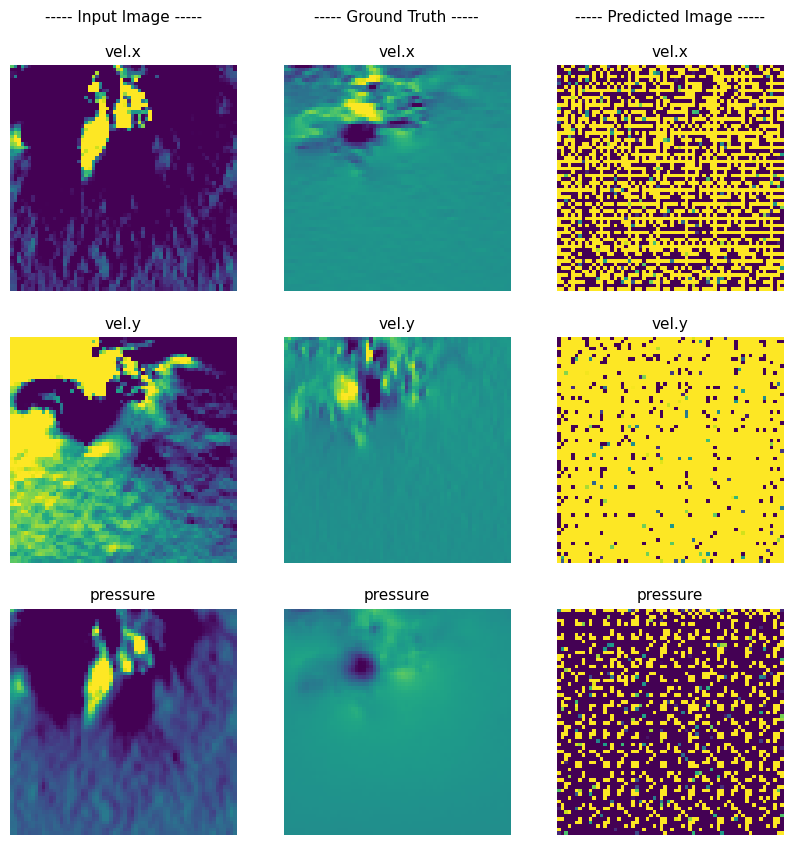

In [11]:
# Test untrained generator and preview.
prev_idx = 10
generate_images(generator, X_train[prev_idx][tf.newaxis, ...], Y_train[prev_idx][tf.newaxis, ...])

In [12]:
# APPLY BATCHING (with 1)
# ... and achieve output dimensionality of:     [2,     n, 64, 64, 3] 
# ... with desired iteration dimensionality of:     [None, 64, 64, 3]
import tensorflow as tf

X_train = tf.cast(X_train, tf.float32)
Y_train = tf.cast(Y_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)

# Normalize data to [-1, 1] range if not already done
# def normalize(x):
#     return tf.clip_by_value(x, -1, 1)

# X_train, Y_train = normalize(X_train), normalize(Y_train)
# X_test, Y_test = normalize(X_test), normalize(Y_test)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(8000).batch(5)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.shuffle(1333).batch(5)


In [13]:
import random
log_dir = "./logs"

%load_ext tensorboard
%reload_ext tensorboard
random_port = random.randrange(1001,9900)
print(f"Loading tensorboard on port: {random_port}")
%tensorboard --logdir={log_dir} --reload_multifile=true --port={random_port} --host localhost

Loading tensorboard on port: 8910


Bottleneck shape before ResNet blocks: (None, 8, 8, 256)


2024-11-18 16:23:30.541137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_2/sequential_9/spatial_dropout2d_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-18 16:23:34.762830: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3d4a5bf9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 16:23:34.762869: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-18 16:23:34.767393: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-18 16:23:34.849083: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

Epoch 1, Batch 0:
Generator Loss: 55.3940,  LR: 2.00e-04
Discriminator Loss: 1.4751,  LR: 5.00e-05
Epoch 1, Batch 200:
Generator Loss: 8.4389,  LR: 2.00e-04
Discriminator Loss: 2.9322,  LR: 5.00e-05
Epoch 1, Batch 400:
Generator Loss: 4.5606,  LR: 2.00e-04
Discriminator Loss: 3.0086,  LR: 5.00e-05
Epoch 1, Batch 600:
Generator Loss: 3.7568,  LR: 2.00e-04
Discriminator Loss: 1.5427,  LR: 5.00e-05
Epoch 1 took 156.34 seconds
Epoch 2, Batch 0:
Generator Loss: 3.1895,  LR: 2.00e-04
Discriminator Loss: 2.1933,  LR: 5.00e-05
Epoch 2, Batch 200:
Generator Loss: 2.9431,  LR: 2.00e-04
Discriminator Loss: 2.8391,  LR: 5.00e-05
Epoch 2, Batch 400:
Generator Loss: 2.9007,  LR: 2.00e-04
Discriminator Loss: 1.9111,  LR: 5.00e-05
Epoch 2, Batch 600:
Generator Loss: 2.8195,  LR: 2.00e-04
Discriminator Loss: 1.0880,  LR: 5.00e-05
Epoch 2 took 121.43 seconds
Epoch 3, Batch 0:
Generator Loss: 2.1690,  LR: 2.00e-04
Discriminator Loss: 0.7445,  LR: 5.00e-05
Epoch 3, Batch 200:
Generator Loss: 2.0061,  LR: 

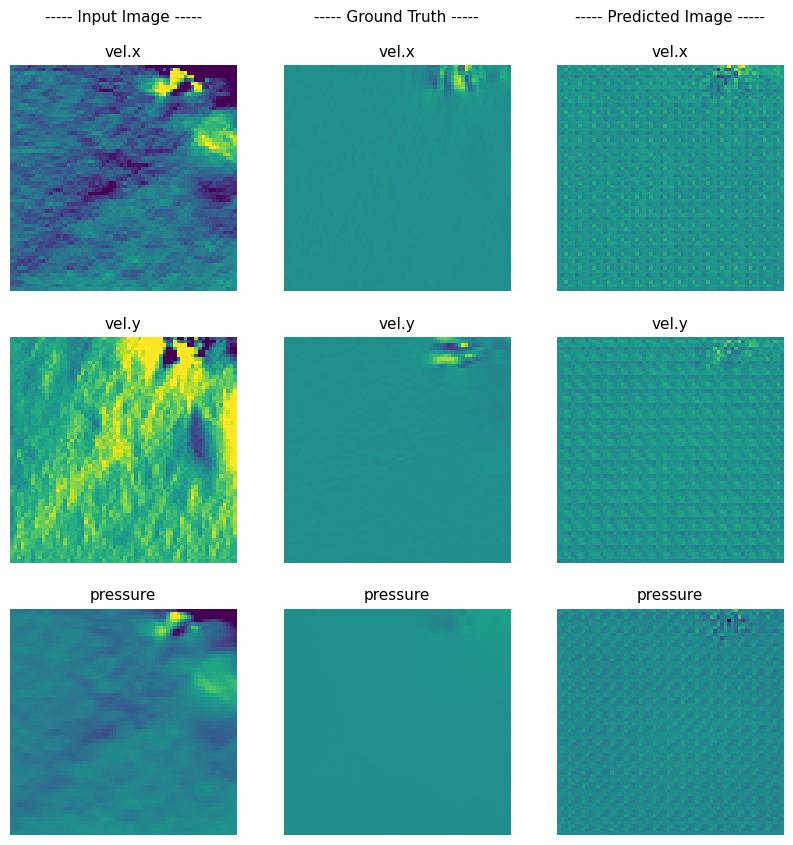

Epoch 5 took 119.52 seconds
Epoch 6, Batch 0:
Generator Loss: 1.6364,  LR: 1.92e-04
Discriminator Loss: 0.4971,  LR: 4.80e-05
Epoch 6, Batch 200:
Generator Loss: 1.6058,  LR: 1.92e-04
Discriminator Loss: 0.5151,  LR: 4.80e-05
Epoch 6, Batch 400:
Generator Loss: 1.5378,  LR: 1.92e-04
Discriminator Loss: 0.5128,  LR: 4.80e-05
Epoch 6, Batch 600:
Generator Loss: 1.5569,  LR: 1.92e-04
Discriminator Loss: 0.5117,  LR: 4.80e-05
Epoch 6 took 119.24 seconds
Epoch 7, Batch 0:
Generator Loss: 1.5906,  LR: 1.92e-04
Discriminator Loss: 0.4920,  LR: 4.80e-05
Epoch 7, Batch 200:
Generator Loss: 1.5433,  LR: 1.92e-04
Discriminator Loss: 0.5041,  LR: 4.80e-05
Epoch 7, Batch 400:
Generator Loss: 1.7176,  LR: 1.92e-04
Discriminator Loss: 0.4920,  LR: 4.80e-05
Epoch 7, Batch 600:
Generator Loss: 1.8087,  LR: 1.92e-04
Discriminator Loss: 0.4891,  LR: 4.80e-05
Epoch 7 took 118.35 seconds
Epoch 8, Batch 0:
Generator Loss: 1.7824,  LR: 1.92e-04
Discriminator Loss: 0.4484,  LR: 4.80e-05
Epoch 8, Batch 200:
Ge

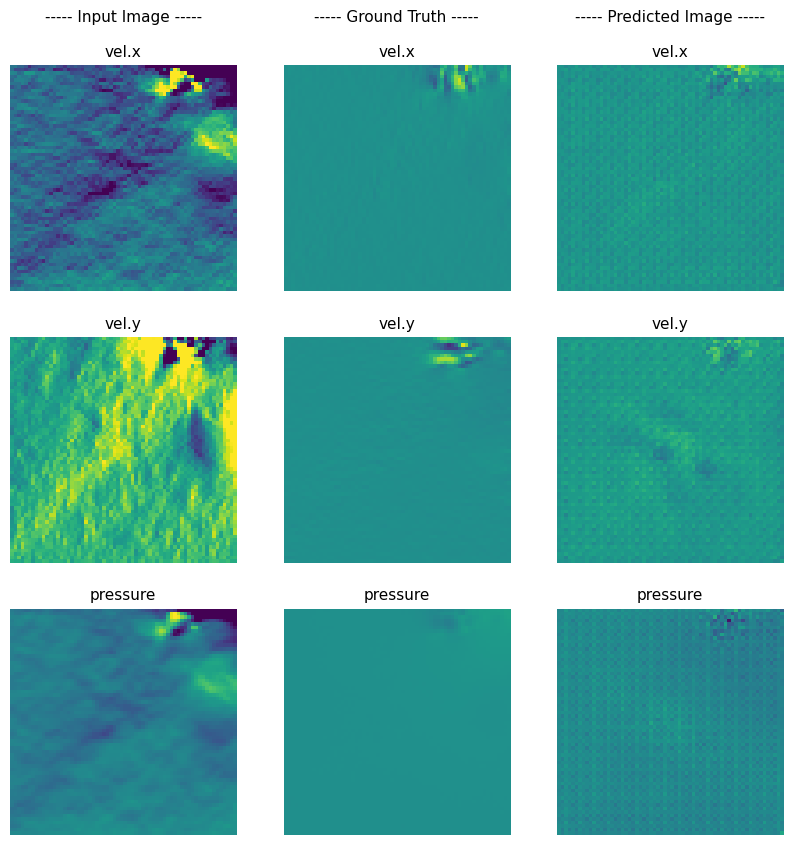

Epoch 10 took 133.64 seconds
Epoch 11, Batch 0:
Generator Loss: 1.5248,  LR: 1.84e-04
Discriminator Loss: 0.4836,  LR: 4.61e-05
Epoch 11, Batch 200:
Generator Loss: 1.4702,  LR: 1.84e-04
Discriminator Loss: 0.5653,  LR: 4.61e-05
Epoch 11, Batch 400:
Generator Loss: 1.3558,  LR: 1.84e-04
Discriminator Loss: 0.5679,  LR: 4.61e-05
Epoch 11, Batch 600:
Generator Loss: 2.0038,  LR: 1.84e-04
Discriminator Loss: 0.4360,  LR: 4.61e-05
Epoch 11 took 118.73 seconds
Epoch 12, Batch 0:
Generator Loss: 1.4233,  LR: 1.84e-04
Discriminator Loss: 0.4517,  LR: 4.61e-05
Epoch 12, Batch 200:
Generator Loss: 1.7277,  LR: 1.84e-04
Discriminator Loss: 0.5171,  LR: 4.61e-05
Epoch 12, Batch 400:
Generator Loss: 1.4141,  LR: 1.84e-04
Discriminator Loss: 0.4789,  LR: 4.61e-05
Epoch 12, Batch 600:
Generator Loss: 1.4906,  LR: 1.84e-04
Discriminator Loss: 0.4334,  LR: 4.61e-05
Epoch 12 took 118.34 seconds
Epoch 13, Batch 0:
Generator Loss: 1.6534,  LR: 1.84e-04
Discriminator Loss: 0.4408,  LR: 4.61e-05
Epoch 13, 

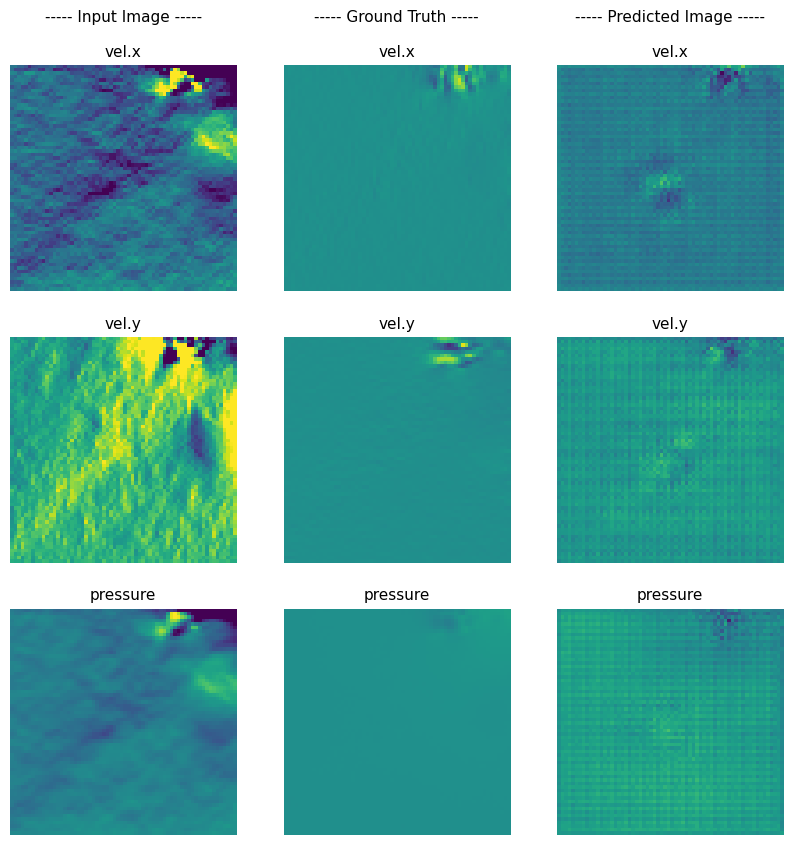

Epoch 15 took 119.81 seconds
Epoch 16, Batch 0:
Generator Loss: 1.7602,  LR: 1.77e-04
Discriminator Loss: 0.4036,  LR: 4.43e-05
Epoch 16, Batch 200:
Generator Loss: 2.2904,  LR: 1.77e-04
Discriminator Loss: 0.1882,  LR: 4.43e-05
Epoch 16, Batch 400:
Generator Loss: 1.4933,  LR: 1.77e-04
Discriminator Loss: 0.3623,  LR: 4.43e-05
Epoch 16, Batch 600:
Generator Loss: 1.6708,  LR: 1.77e-04
Discriminator Loss: 0.2099,  LR: 4.43e-05
Epoch 16 took 118.69 seconds
Epoch 17, Batch 0:
Generator Loss: 2.5302,  LR: 1.77e-04
Discriminator Loss: 0.1887,  LR: 4.43e-05
Epoch 17, Batch 200:
Generator Loss: 2.3473,  LR: 1.77e-04
Discriminator Loss: 0.2908,  LR: 4.43e-05
Epoch 17, Batch 400:
Generator Loss: 2.1348,  LR: 1.77e-04
Discriminator Loss: 0.2301,  LR: 4.43e-05
Epoch 17, Batch 600:
Generator Loss: 2.3799,  LR: 1.77e-04
Discriminator Loss: 0.2220,  LR: 4.43e-05
Epoch 17 took 119.18 seconds
Epoch 18, Batch 0:
Generator Loss: 2.4015,  LR: 1.77e-04
Discriminator Loss: 0.1814,  LR: 4.43e-05
Epoch 18, 

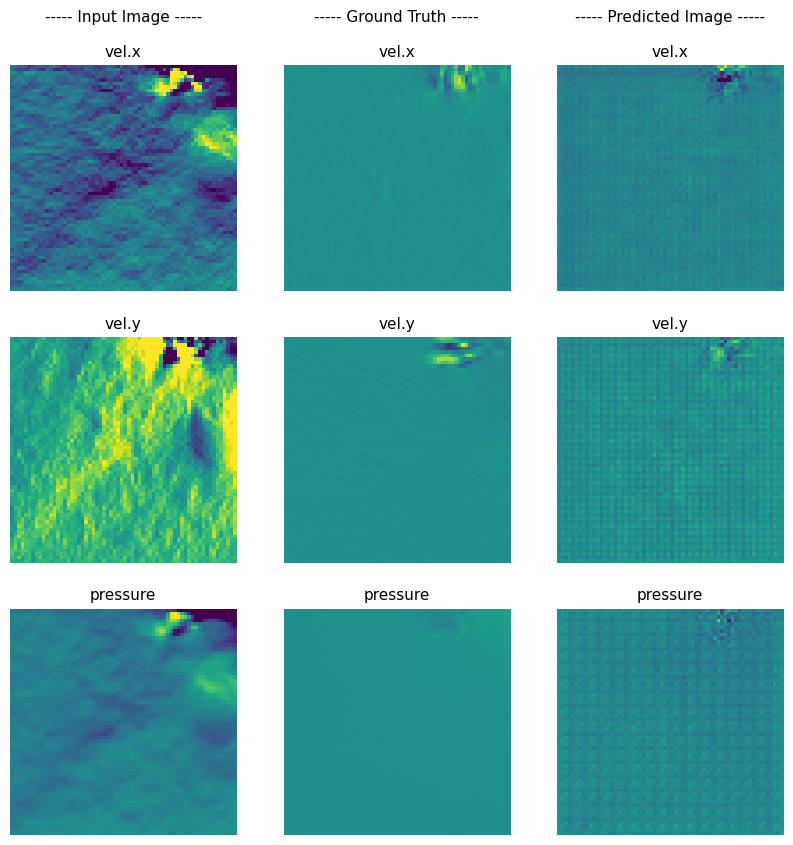

Checkpoint saved for epoch 20
Epoch 20 took 130.12 seconds
Epoch 21, Batch 0:
Generator Loss: 1.5034,  LR: 1.70e-04
Discriminator Loss: 0.1024,  LR: 4.25e-05
Epoch 21, Batch 200:
Generator Loss: 2.5470,  LR: 1.70e-04
Discriminator Loss: 0.1246,  LR: 4.25e-05
Epoch 21, Batch 400:
Generator Loss: 1.9489,  LR: 1.70e-04
Discriminator Loss: 0.1498,  LR: 4.25e-05
Epoch 21, Batch 600:
Generator Loss: 2.6290,  LR: 1.70e-04
Discriminator Loss: 0.1672,  LR: 4.25e-05
Epoch 21 took 121.18 seconds
Epoch 22, Batch 0:
Generator Loss: 2.0827,  LR: 1.70e-04
Discriminator Loss: 0.1652,  LR: 4.25e-05
Epoch 22, Batch 200:
Generator Loss: 2.1875,  LR: 1.70e-04
Discriminator Loss: 0.1333,  LR: 4.25e-05
Epoch 22, Batch 400:
Generator Loss: 3.5350,  LR: 1.70e-04
Discriminator Loss: 0.0619,  LR: 4.25e-05
Epoch 22, Batch 600:
Generator Loss: 2.2406,  LR: 1.70e-04
Discriminator Loss: 0.1138,  LR: 4.25e-05
Epoch 22 took 121.36 seconds
Epoch 23, Batch 0:
Generator Loss: 1.7496,  LR: 1.70e-04
Discriminator Loss: 0.

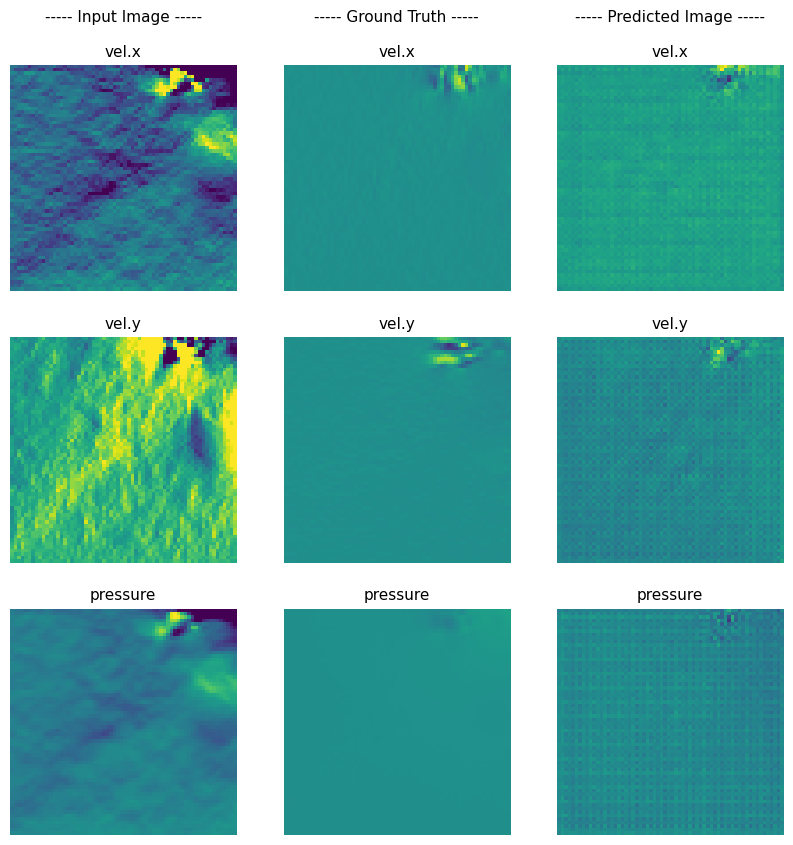

Epoch 25 took 122.45 seconds
Epoch 26, Batch 0:
Generator Loss: 2.4725,  LR: 1.63e-04
Discriminator Loss: 0.2140,  LR: 4.09e-05
Epoch 26, Batch 200:
Generator Loss: 2.1513,  LR: 1.63e-04
Discriminator Loss: 0.3338,  LR: 4.09e-05
Epoch 26, Batch 400:
Generator Loss: 2.3716,  LR: 1.63e-04
Discriminator Loss: 0.1379,  LR: 4.09e-05
Epoch 26, Batch 600:
Generator Loss: 2.8002,  LR: 1.63e-04
Discriminator Loss: 0.2043,  LR: 4.09e-05
Epoch 26 took 119.67 seconds
Epoch 27, Batch 0:
Generator Loss: 2.2084,  LR: 1.63e-04
Discriminator Loss: 0.2853,  LR: 4.09e-05
Epoch 27, Batch 200:
Generator Loss: 2.9128,  LR: 1.63e-04
Discriminator Loss: 0.1911,  LR: 4.09e-05
Epoch 27, Batch 400:
Generator Loss: 2.3718,  LR: 1.63e-04
Discriminator Loss: 0.1646,  LR: 4.09e-05
Epoch 27, Batch 600:
Generator Loss: 2.4454,  LR: 1.63e-04
Discriminator Loss: 0.2614,  LR: 4.09e-05
Epoch 27 took 119.77 seconds
Epoch 28, Batch 0:
Generator Loss: 1.8107,  LR: 1.63e-04
Discriminator Loss: 0.1016,  LR: 4.09e-05
Epoch 28, 

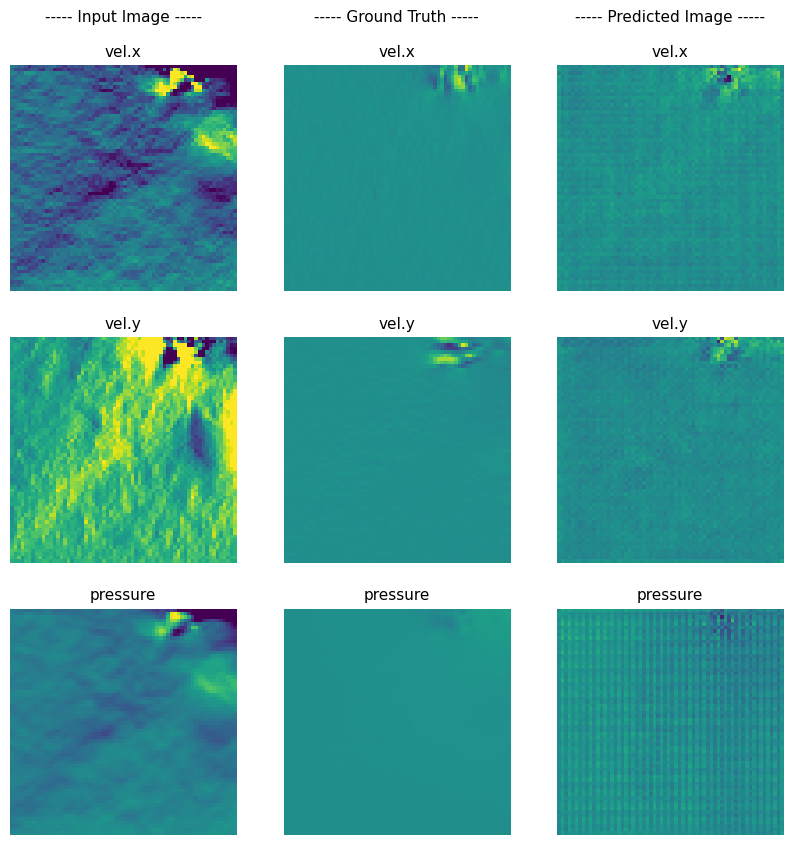

Epoch 30 took 127.98 seconds
Epoch 31, Batch 0:
Generator Loss: 1.7428,  LR: 1.57e-04
Discriminator Loss: 0.2738,  LR: 3.92e-05
Epoch 31, Batch 200:
Generator Loss: 2.5495,  LR: 1.57e-04
Discriminator Loss: 0.1903,  LR: 3.92e-05
Epoch 31, Batch 400:
Generator Loss: 2.2632,  LR: 1.57e-04
Discriminator Loss: 0.0793,  LR: 3.92e-05
Epoch 31, Batch 600:
Generator Loss: 2.6414,  LR: 1.57e-04
Discriminator Loss: 0.0961,  LR: 3.92e-05
Epoch 31 took 119.28 seconds
Epoch 32, Batch 0:
Generator Loss: 2.4141,  LR: 1.57e-04
Discriminator Loss: 0.1350,  LR: 3.92e-05
Epoch 32, Batch 200:
Generator Loss: 2.3807,  LR: 1.57e-04
Discriminator Loss: 0.0801,  LR: 3.92e-05
Epoch 32, Batch 400:
Generator Loss: 1.5539,  LR: 1.57e-04
Discriminator Loss: 0.0978,  LR: 3.92e-05
Epoch 32, Batch 600:
Generator Loss: 2.6650,  LR: 1.57e-04
Discriminator Loss: 0.0823,  LR: 3.92e-05
Epoch 32 took 119.27 seconds
Epoch 33, Batch 0:
Generator Loss: 1.5767,  LR: 1.57e-04
Discriminator Loss: 0.0864,  LR: 3.92e-05
Epoch 33, 

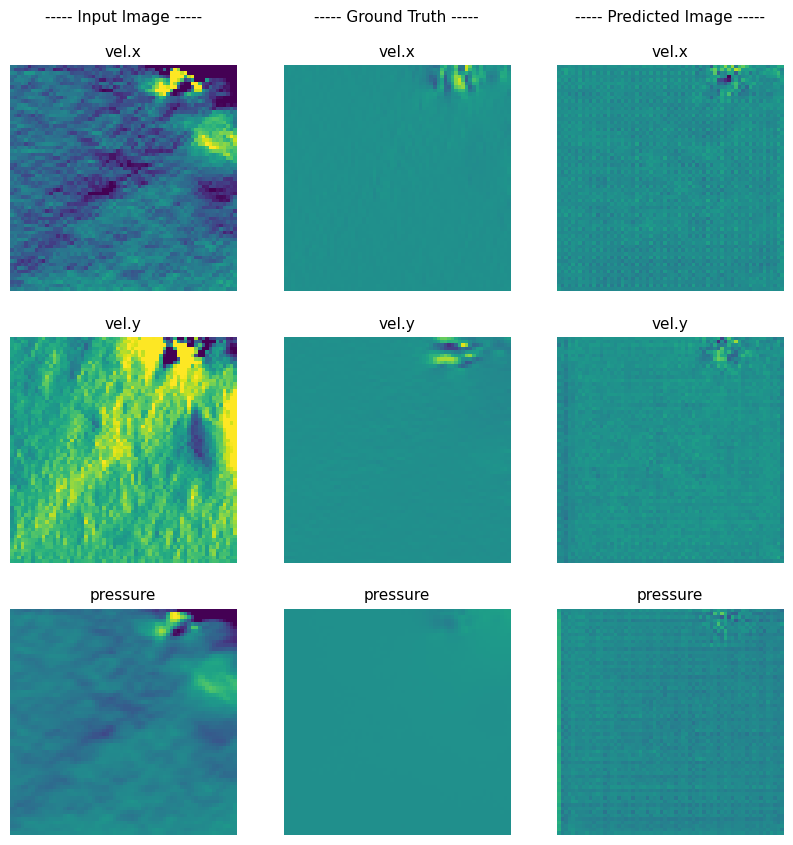

Epoch 35 took 121.75 seconds
Epoch 36, Batch 0:
Generator Loss: 3.1687,  LR: 1.51e-04
Discriminator Loss: 0.0982,  LR: 3.77e-05
Epoch 36, Batch 200:
Generator Loss: 1.9131,  LR: 1.51e-04
Discriminator Loss: 0.1390,  LR: 3.77e-05
Epoch 36, Batch 400:
Generator Loss: 2.6402,  LR: 1.51e-04
Discriminator Loss: 0.1672,  LR: 3.77e-05
Epoch 36, Batch 600:
Generator Loss: 2.3962,  LR: 1.51e-04
Discriminator Loss: 0.1446,  LR: 3.77e-05
Epoch 36 took 118.91 seconds
Epoch 37, Batch 0:
Generator Loss: 2.2187,  LR: 1.51e-04
Discriminator Loss: 0.2248,  LR: 3.77e-05
Epoch 37, Batch 200:
Generator Loss: 1.9201,  LR: 1.51e-04
Discriminator Loss: 0.1349,  LR: 3.77e-05
Epoch 37, Batch 400:
Generator Loss: 2.8628,  LR: 1.51e-04
Discriminator Loss: 0.0892,  LR: 3.77e-05
Epoch 37, Batch 600:
Generator Loss: 2.6246,  LR: 1.51e-04
Discriminator Loss: 0.2045,  LR: 3.77e-05
Epoch 37 took 120.63 seconds
Epoch 38, Batch 0:
Generator Loss: 2.7577,  LR: 1.51e-04
Discriminator Loss: 0.2491,  LR: 3.77e-05
Epoch 38, 

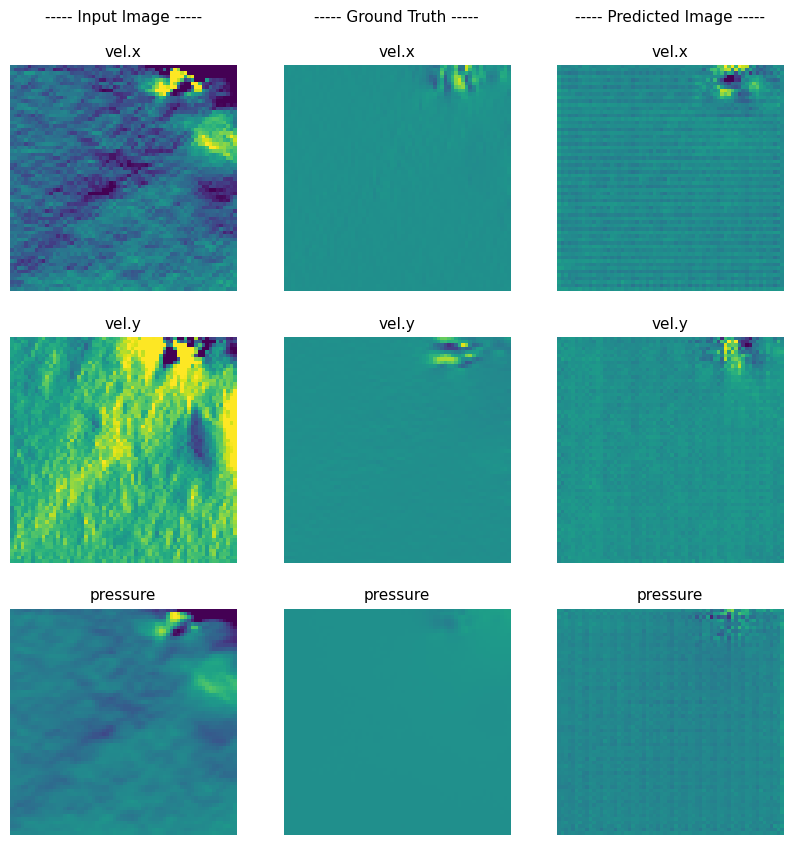

Checkpoint saved for epoch 40
Epoch 40 took 131.81 seconds
Epoch 41, Batch 0:
Generator Loss: 1.6028,  LR: 1.45e-04
Discriminator Loss: 0.2759,  LR: 3.62e-05
Epoch 41, Batch 200:
Generator Loss: 2.1282,  LR: 1.45e-04
Discriminator Loss: 0.2537,  LR: 3.62e-05
Epoch 41, Batch 400:
Generator Loss: 1.9389,  LR: 1.45e-04
Discriminator Loss: 0.2450,  LR: 3.62e-05
Epoch 41, Batch 600:
Generator Loss: 3.0458,  LR: 1.45e-04
Discriminator Loss: 0.1410,  LR: 3.62e-05
Epoch 41 took 120.38 seconds
Epoch 42, Batch 0:
Generator Loss: 2.3014,  LR: 1.45e-04
Discriminator Loss: 0.1519,  LR: 3.62e-05
Epoch 42, Batch 200:
Generator Loss: 2.6011,  LR: 1.45e-04
Discriminator Loss: 0.1214,  LR: 3.62e-05
Epoch 42, Batch 400:
Generator Loss: 2.6265,  LR: 1.45e-04
Discriminator Loss: 0.0923,  LR: 3.62e-05
Epoch 42, Batch 600:
Generator Loss: 1.3905,  LR: 1.45e-04
Discriminator Loss: 0.1598,  LR: 3.62e-05
Epoch 42 took 119.88 seconds
Epoch 43, Batch 0:
Generator Loss: 2.3399,  LR: 1.45e-04
Discriminator Loss: 0.

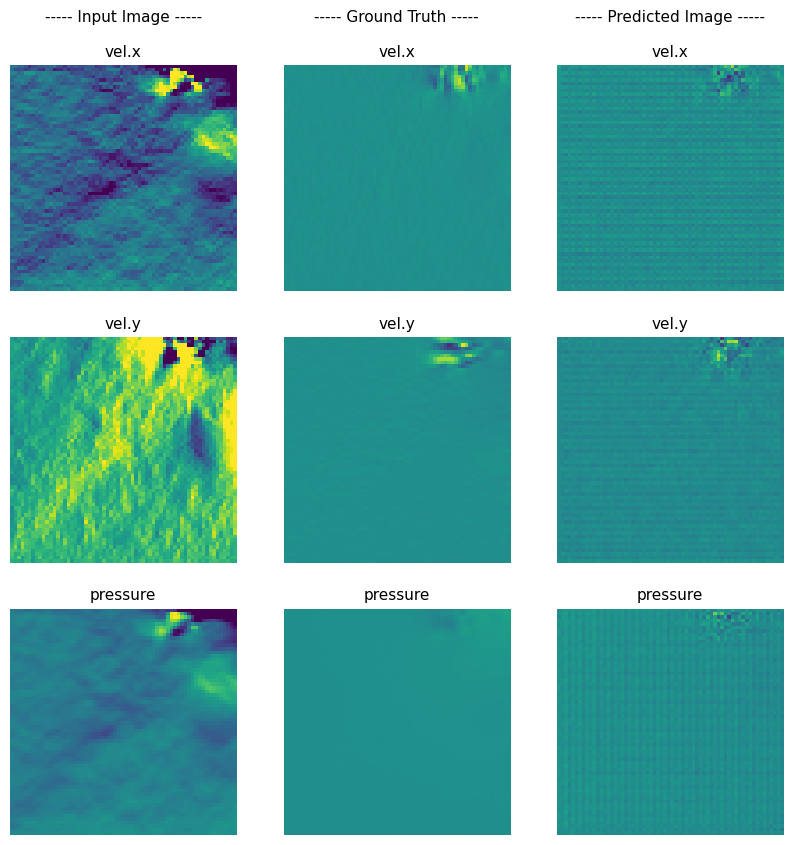

Epoch 45 took 121.57 seconds
Epoch 46, Batch 0:
Generator Loss: 2.5684,  LR: 1.39e-04
Discriminator Loss: 0.0306,  LR: 3.48e-05
Epoch 46, Batch 200:
Generator Loss: 2.1182,  LR: 1.39e-04
Discriminator Loss: 0.1721,  LR: 3.48e-05
Epoch 46, Batch 400:
Generator Loss: 2.3461,  LR: 1.39e-04
Discriminator Loss: 0.1170,  LR: 3.48e-05
Epoch 46, Batch 600:
Generator Loss: 1.9770,  LR: 1.39e-04
Discriminator Loss: 0.2047,  LR: 3.48e-05
Epoch 46 took 117.15 seconds
Epoch 47, Batch 0:
Generator Loss: 2.8589,  LR: 1.39e-04
Discriminator Loss: 0.0688,  LR: 3.48e-05
Epoch 47, Batch 200:
Generator Loss: 2.7671,  LR: 1.39e-04
Discriminator Loss: 0.0842,  LR: 3.48e-05
Epoch 47, Batch 400:
Generator Loss: 2.3174,  LR: 1.39e-04
Discriminator Loss: 0.2652,  LR: 3.48e-05
Epoch 47, Batch 600:
Generator Loss: 2.2200,  LR: 1.39e-04
Discriminator Loss: 0.3865,  LR: 3.48e-05
Epoch 47 took 118.31 seconds
Epoch 48, Batch 0:
Generator Loss: 1.7977,  LR: 1.39e-04
Discriminator Loss: 0.3040,  LR: 3.48e-05
Epoch 48, 

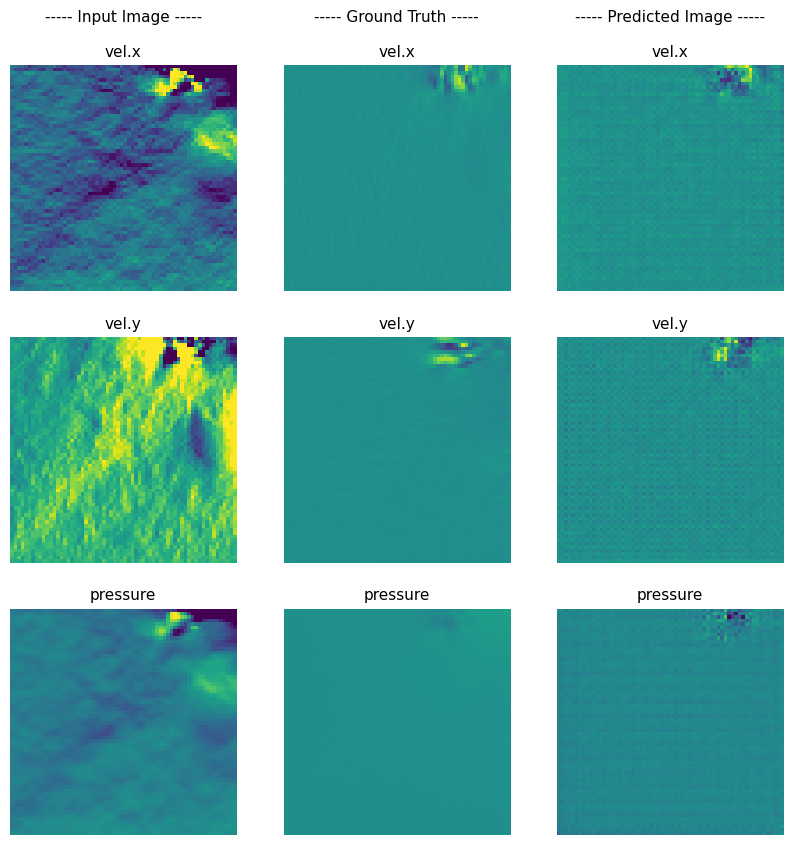

Epoch 50 took 129.93 seconds
Epoch 51, Batch 0:
Generator Loss: 1.5472,  LR: 1.34e-04
Discriminator Loss: 0.3376,  LR: 3.34e-05
Epoch 51, Batch 200:
Generator Loss: 1.8752,  LR: 1.34e-04
Discriminator Loss: 0.2701,  LR: 3.34e-05
Epoch 51, Batch 400:
Generator Loss: 2.2963,  LR: 1.34e-04
Discriminator Loss: 0.1509,  LR: 3.34e-05
Epoch 51, Batch 600:
Generator Loss: 1.8800,  LR: 1.34e-04
Discriminator Loss: 0.2442,  LR: 3.34e-05
Epoch 51 took 121.25 seconds
Epoch 52, Batch 0:
Generator Loss: 1.5857,  LR: 1.34e-04
Discriminator Loss: 0.4814,  LR: 3.34e-05
Epoch 52, Batch 200:
Generator Loss: 1.8644,  LR: 1.34e-04
Discriminator Loss: 0.2896,  LR: 3.34e-05
Epoch 52, Batch 400:
Generator Loss: 3.1218,  LR: 1.34e-04
Discriminator Loss: 0.1289,  LR: 3.34e-05
Epoch 52, Batch 600:
Generator Loss: 2.0073,  LR: 1.34e-04
Discriminator Loss: 0.2119,  LR: 3.34e-05
Epoch 52 took 120.20 seconds
Epoch 53, Batch 0:
Generator Loss: 2.0566,  LR: 1.34e-04
Discriminator Loss: 0.4314,  LR: 3.34e-05
Epoch 53, 

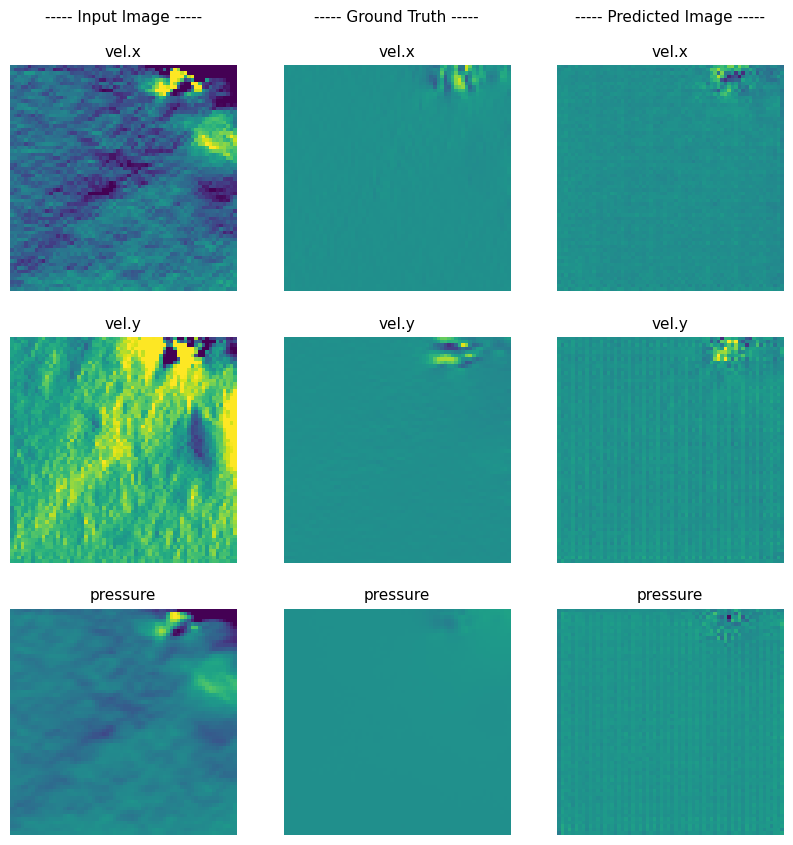

Epoch 55 took 121.19 seconds
Epoch 56, Batch 0:
Generator Loss: 2.1482,  LR: 1.28e-04
Discriminator Loss: 0.2604,  LR: 3.21e-05
Epoch 56, Batch 200:
Generator Loss: 2.6202,  LR: 1.28e-04
Discriminator Loss: 0.1424,  LR: 3.21e-05
Epoch 56, Batch 400:
Generator Loss: 1.5701,  LR: 1.28e-04
Discriminator Loss: 0.2330,  LR: 3.21e-05
Epoch 56, Batch 600:
Generator Loss: 1.8318,  LR: 1.28e-04
Discriminator Loss: 0.2106,  LR: 3.21e-05
Epoch 56 took 119.22 seconds
Epoch 57, Batch 0:
Generator Loss: 1.6037,  LR: 1.28e-04
Discriminator Loss: 0.2495,  LR: 3.21e-05
Epoch 57, Batch 200:
Generator Loss: 2.1157,  LR: 1.28e-04
Discriminator Loss: 0.0847,  LR: 3.21e-05
Epoch 57, Batch 400:
Generator Loss: 2.4949,  LR: 1.28e-04
Discriminator Loss: 0.2272,  LR: 3.21e-05
Epoch 57, Batch 600:
Generator Loss: 2.3187,  LR: 1.28e-04
Discriminator Loss: 0.1082,  LR: 3.21e-05
Epoch 57 took 119.93 seconds
Epoch 58, Batch 0:
Generator Loss: 1.4505,  LR: 1.28e-04
Discriminator Loss: 0.3384,  LR: 3.21e-05
Epoch 58, 

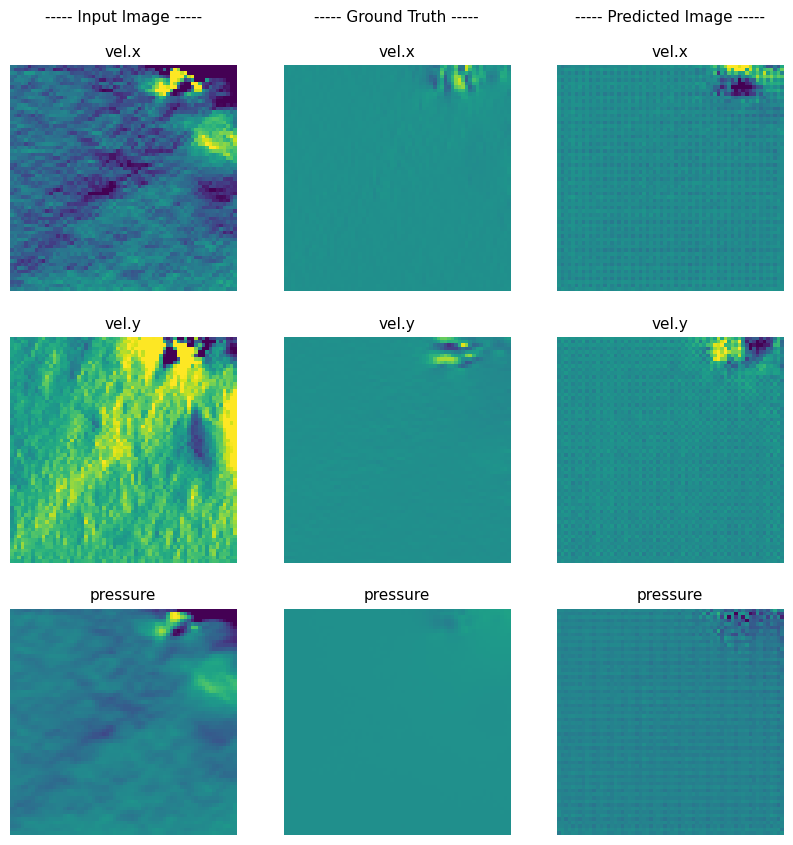

Checkpoint saved for epoch 60
Epoch 60 took 131.79 seconds
Epoch 61, Batch 0:
Generator Loss: 3.0387,  LR: 1.23e-04
Discriminator Loss: 0.1436,  LR: 3.08e-05
Epoch 61, Batch 200:
Generator Loss: 1.5660,  LR: 1.23e-04
Discriminator Loss: 0.1085,  LR: 3.08e-05
Epoch 61, Batch 400:
Generator Loss: 1.5278,  LR: 1.23e-04
Discriminator Loss: 0.3103,  LR: 3.08e-05
Epoch 61, Batch 600:
Generator Loss: 2.9668,  LR: 1.23e-04
Discriminator Loss: 0.1080,  LR: 3.08e-05
Epoch 61 took 121.49 seconds
Epoch 62, Batch 0:
Generator Loss: 2.0116,  LR: 1.23e-04
Discriminator Loss: 0.2118,  LR: 3.08e-05
Epoch 62, Batch 200:
Generator Loss: 1.9656,  LR: 1.23e-04
Discriminator Loss: 0.2227,  LR: 3.08e-05
Epoch 62, Batch 400:
Generator Loss: 2.1103,  LR: 1.23e-04
Discriminator Loss: 0.2064,  LR: 3.08e-05
Epoch 62, Batch 600:
Generator Loss: 2.2054,  LR: 1.23e-04
Discriminator Loss: 0.2144,  LR: 3.08e-05
Epoch 62 took 120.65 seconds
Epoch 63, Batch 0:
Generator Loss: 2.1040,  LR: 1.23e-04
Discriminator Loss: 0.

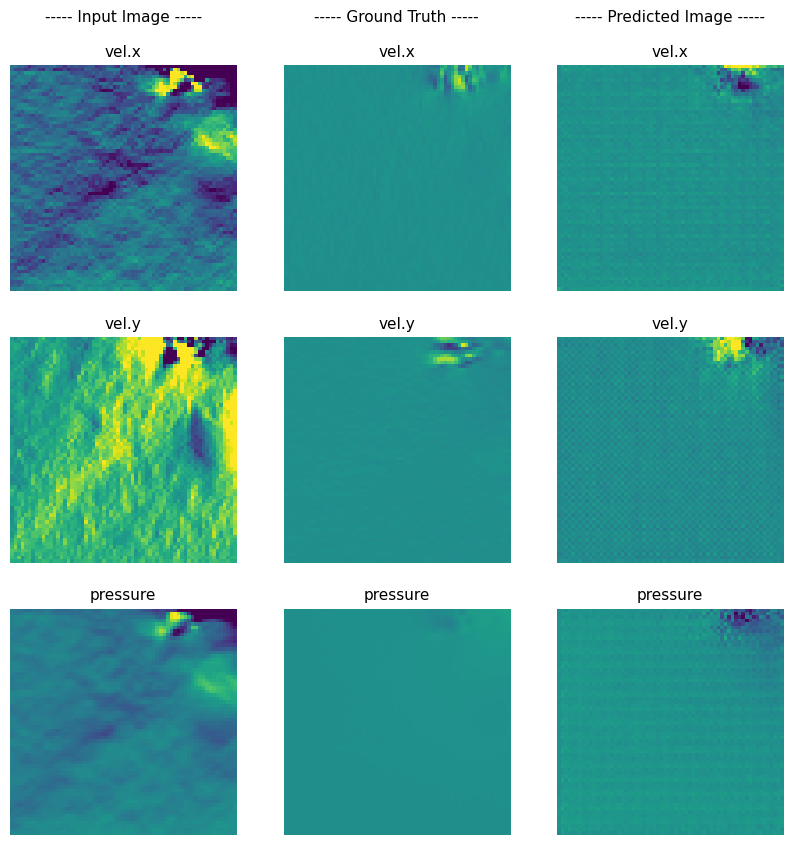

Epoch 65 took 120.99 seconds
Epoch 66, Batch 0:
Generator Loss: 1.9733,  LR: 1.18e-04
Discriminator Loss: 0.1469,  LR: 2.96e-05
Epoch 66, Batch 200:
Generator Loss: 1.6849,  LR: 1.18e-04
Discriminator Loss: 0.2333,  LR: 2.96e-05
Epoch 66, Batch 400:
Generator Loss: 2.3081,  LR: 1.18e-04
Discriminator Loss: 0.1840,  LR: 2.96e-05
Epoch 66, Batch 600:
Generator Loss: 1.1802,  LR: 1.18e-04
Discriminator Loss: 0.3042,  LR: 2.96e-05
Epoch 66 took 121.11 seconds
Epoch 67, Batch 0:
Generator Loss: 1.9025,  LR: 1.18e-04
Discriminator Loss: 0.1537,  LR: 2.96e-05
Epoch 67, Batch 200:
Generator Loss: 2.7026,  LR: 1.18e-04
Discriminator Loss: 0.0502,  LR: 2.96e-05
Epoch 67, Batch 400:
Generator Loss: 1.6238,  LR: 1.18e-04
Discriminator Loss: 0.1211,  LR: 2.96e-05
Epoch 67, Batch 600:
Generator Loss: 1.6515,  LR: 1.18e-04
Discriminator Loss: 0.4313,  LR: 2.96e-05
Epoch 67 took 119.95 seconds
Epoch 68, Batch 0:
Generator Loss: 1.8782,  LR: 1.18e-04
Discriminator Loss: 0.1292,  LR: 2.96e-05
Epoch 68, 

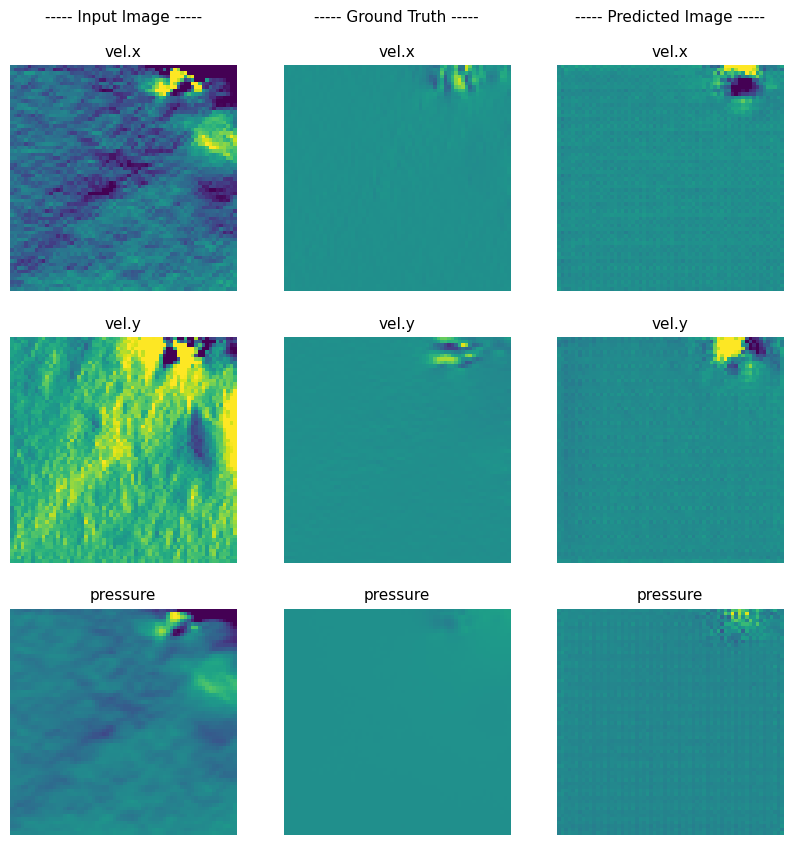

Epoch 70 took 129.37 seconds
Epoch 71, Batch 0:
Generator Loss: 1.1060,  LR: 1.14e-04
Discriminator Loss: 0.2830,  LR: 2.84e-05
Epoch 71, Batch 200:
Generator Loss: 1.6624,  LR: 1.14e-04
Discriminator Loss: 0.1472,  LR: 2.84e-05
Epoch 71, Batch 400:
Generator Loss: 2.0496,  LR: 1.14e-04
Discriminator Loss: 0.2074,  LR: 2.84e-05
Epoch 71, Batch 600:
Generator Loss: 1.9443,  LR: 1.14e-04
Discriminator Loss: 0.1175,  LR: 2.84e-05
Epoch 71 took 120.52 seconds
Epoch 72, Batch 0:
Generator Loss: 1.9698,  LR: 1.14e-04
Discriminator Loss: 0.0646,  LR: 2.84e-05
Epoch 72, Batch 200:
Generator Loss: 1.4000,  LR: 1.14e-04
Discriminator Loss: 0.3074,  LR: 2.84e-05
Epoch 72, Batch 400:
Generator Loss: 1.5864,  LR: 1.14e-04
Discriminator Loss: 0.2117,  LR: 2.84e-05
Epoch 72, Batch 600:
Generator Loss: 1.6440,  LR: 1.14e-04
Discriminator Loss: 0.2010,  LR: 2.84e-05
Epoch 72 took 119.73 seconds
Epoch 73, Batch 0:
Generator Loss: 2.0784,  LR: 1.14e-04
Discriminator Loss: 0.2152,  LR: 2.84e-05
Epoch 73, 

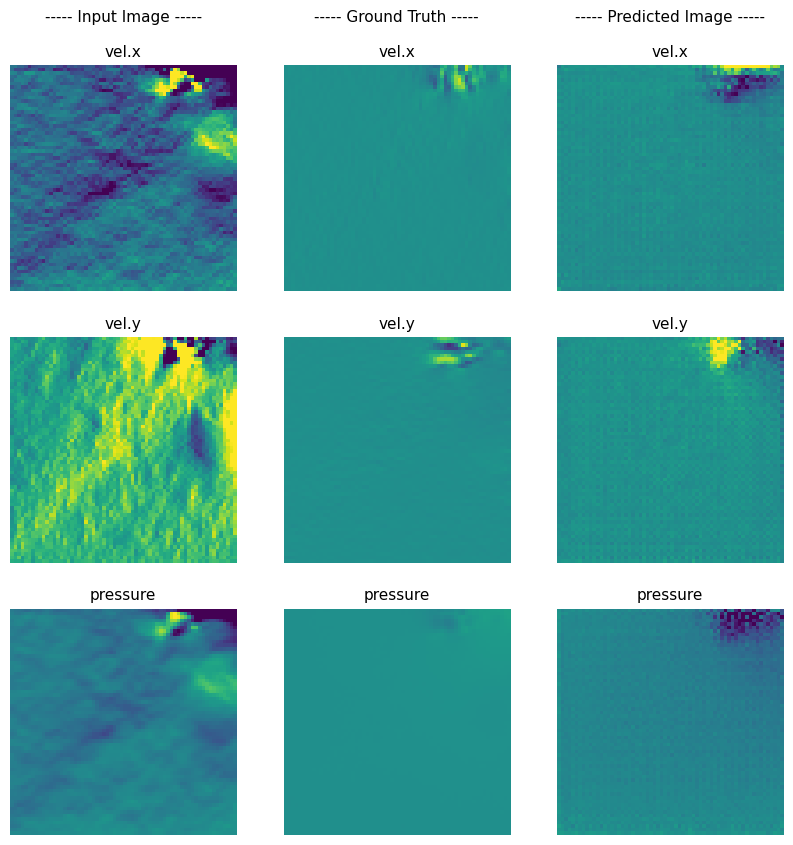

Epoch 75 took 120.90 seconds
Epoch 76, Batch 0:
Generator Loss: 2.1017,  LR: 1.09e-04
Discriminator Loss: 0.2293,  LR: 2.73e-05
Epoch 76, Batch 200:
Generator Loss: 1.8403,  LR: 1.09e-04
Discriminator Loss: 0.1904,  LR: 2.73e-05
Epoch 76, Batch 400:
Generator Loss: 1.5562,  LR: 1.09e-04
Discriminator Loss: 0.0791,  LR: 2.73e-05
Epoch 76, Batch 600:
Generator Loss: 1.2817,  LR: 1.09e-04
Discriminator Loss: 0.2641,  LR: 2.73e-05
Epoch 76 took 120.57 seconds
Epoch 77, Batch 0:
Generator Loss: 1.9940,  LR: 1.09e-04
Discriminator Loss: 0.1410,  LR: 2.73e-05
Epoch 77, Batch 200:
Generator Loss: 1.3983,  LR: 1.09e-04
Discriminator Loss: 0.1516,  LR: 2.73e-05
Epoch 77, Batch 400:
Generator Loss: 1.4954,  LR: 1.09e-04
Discriminator Loss: 0.1973,  LR: 2.73e-05
Epoch 77, Batch 600:
Generator Loss: 1.3067,  LR: 1.09e-04
Discriminator Loss: 0.1832,  LR: 2.73e-05
Epoch 77 took 120.08 seconds
Epoch 78, Batch 0:
Generator Loss: 2.4771,  LR: 1.09e-04
Discriminator Loss: 0.1134,  LR: 2.73e-05
Epoch 78, 

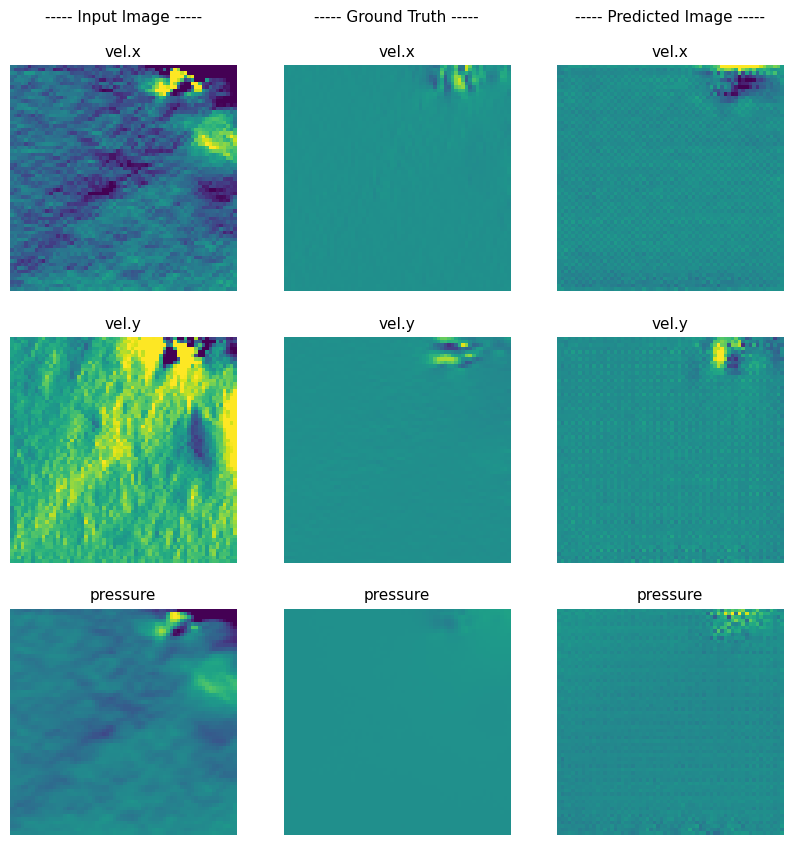

Checkpoint saved for epoch 80
Epoch 80 took 130.98 seconds
Epoch 81, Batch 0:
Generator Loss: 1.9570,  LR: 1.05e-04
Discriminator Loss: 0.0952,  LR: 2.62e-05
Epoch 81, Batch 200:
Generator Loss: 1.8828,  LR: 1.05e-04
Discriminator Loss: 0.1133,  LR: 2.62e-05
Epoch 81, Batch 400:
Generator Loss: 1.6429,  LR: 1.05e-04
Discriminator Loss: 0.3216,  LR: 2.62e-05
Epoch 81, Batch 600:
Generator Loss: 1.3053,  LR: 1.05e-04
Discriminator Loss: 0.1047,  LR: 2.62e-05
Epoch 81 took 121.51 seconds
Epoch 82, Batch 0:
Generator Loss: 1.0419,  LR: 1.05e-04
Discriminator Loss: 0.1558,  LR: 2.62e-05
Epoch 82, Batch 200:
Generator Loss: 1.3421,  LR: 1.05e-04
Discriminator Loss: 0.1767,  LR: 2.62e-05
Epoch 82, Batch 400:
Generator Loss: 1.9639,  LR: 1.05e-04
Discriminator Loss: 0.0464,  LR: 2.62e-05
Epoch 82, Batch 600:
Generator Loss: 1.6345,  LR: 1.05e-04
Discriminator Loss: 0.1228,  LR: 2.62e-05
Epoch 82 took 120.63 seconds
Epoch 83, Batch 0:
Generator Loss: 1.5664,  LR: 1.05e-04
Discriminator Loss: 0.

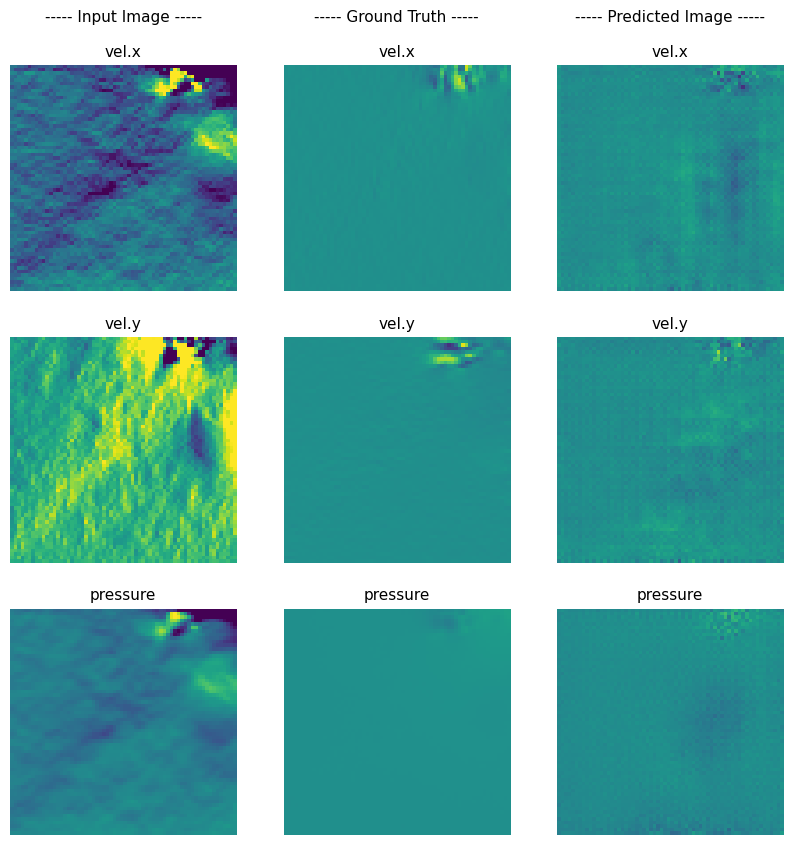

Epoch 85 took 121.65 seconds
Epoch 86, Batch 0:
Generator Loss: 1.6524,  LR: 1.01e-04
Discriminator Loss: 0.1624,  LR: 2.52e-05
Epoch 86, Batch 200:
Generator Loss: 1.1624,  LR: 1.01e-04
Discriminator Loss: 0.1993,  LR: 2.52e-05
Epoch 86, Batch 400:
Generator Loss: 1.5956,  LR: 1.01e-04
Discriminator Loss: 0.0521,  LR: 2.52e-05
Epoch 86, Batch 600:
Generator Loss: 2.0168,  LR: 1.01e-04
Discriminator Loss: 0.1212,  LR: 2.52e-05
Epoch 86 took 121.15 seconds
Epoch 87, Batch 0:
Generator Loss: 1.9565,  LR: 1.01e-04
Discriminator Loss: 0.1316,  LR: 2.52e-05
Epoch 87, Batch 200:
Generator Loss: 1.2675,  LR: 1.01e-04
Discriminator Loss: 0.1841,  LR: 2.52e-05
Epoch 87, Batch 400:
Generator Loss: 1.8825,  LR: 1.01e-04
Discriminator Loss: 0.1783,  LR: 2.52e-05
Epoch 87, Batch 600:
Generator Loss: 1.1560,  LR: 1.01e-04
Discriminator Loss: 0.1217,  LR: 2.52e-05
Epoch 87 took 121.61 seconds
Epoch 88, Batch 0:
Generator Loss: 1.4657,  LR: 1.01e-04
Discriminator Loss: 0.0656,  LR: 2.52e-05
Epoch 88, 

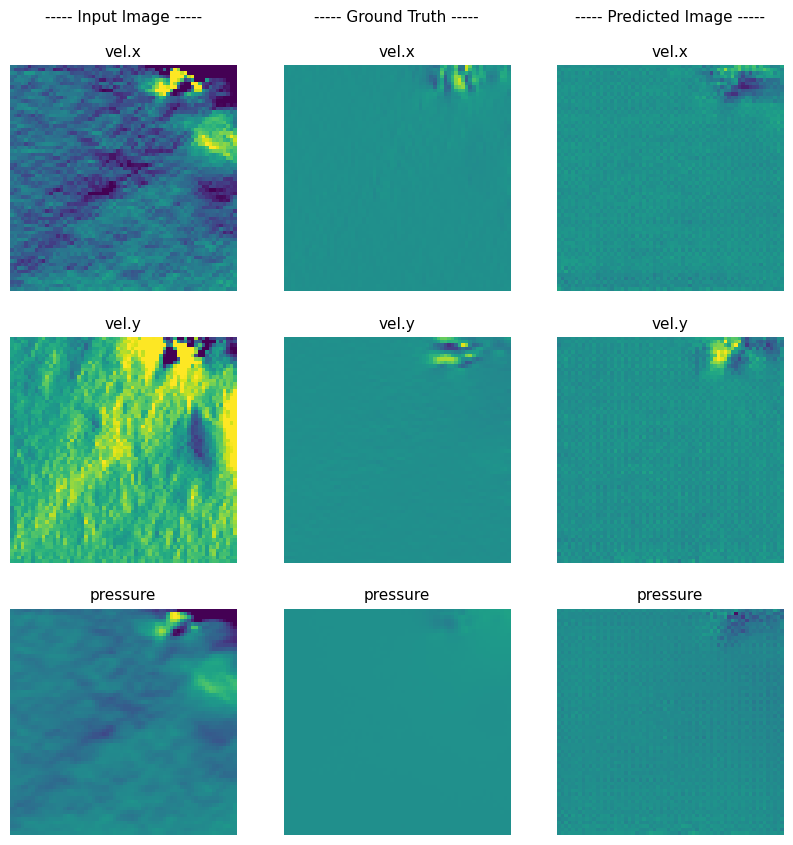

Epoch 90 took 129.60 seconds
Epoch 91, Batch 0:
Generator Loss: 2.8504,  LR: 9.66e-05
Discriminator Loss: 0.0978,  LR: 2.42e-05
Epoch 91, Batch 200:
Generator Loss: 2.7047,  LR: 9.66e-05
Discriminator Loss: 0.0451,  LR: 2.42e-05
Epoch 91, Batch 400:
Generator Loss: 1.6606,  LR: 9.66e-05
Discriminator Loss: 0.0959,  LR: 2.42e-05
Epoch 91, Batch 600:
Generator Loss: 1.6129,  LR: 9.66e-05
Discriminator Loss: 0.0310,  LR: 2.42e-05
Epoch 91 took 120.01 seconds
Epoch 92, Batch 0:
Generator Loss: 2.0764,  LR: 9.66e-05
Discriminator Loss: 0.0547,  LR: 2.42e-05
Epoch 92, Batch 200:
Generator Loss: 2.6994,  LR: 9.66e-05
Discriminator Loss: 0.0266,  LR: 2.42e-05
Epoch 92, Batch 400:
Generator Loss: 1.7575,  LR: 9.66e-05
Discriminator Loss: 0.0602,  LR: 2.42e-05
Epoch 92, Batch 600:
Generator Loss: 1.2861,  LR: 9.66e-05
Discriminator Loss: 0.0590,  LR: 2.42e-05
Epoch 92 took 119.58 seconds
Epoch 93, Batch 0:
Generator Loss: 1.3225,  LR: 9.66e-05
Discriminator Loss: 0.2054,  LR: 2.42e-05
Epoch 93, 

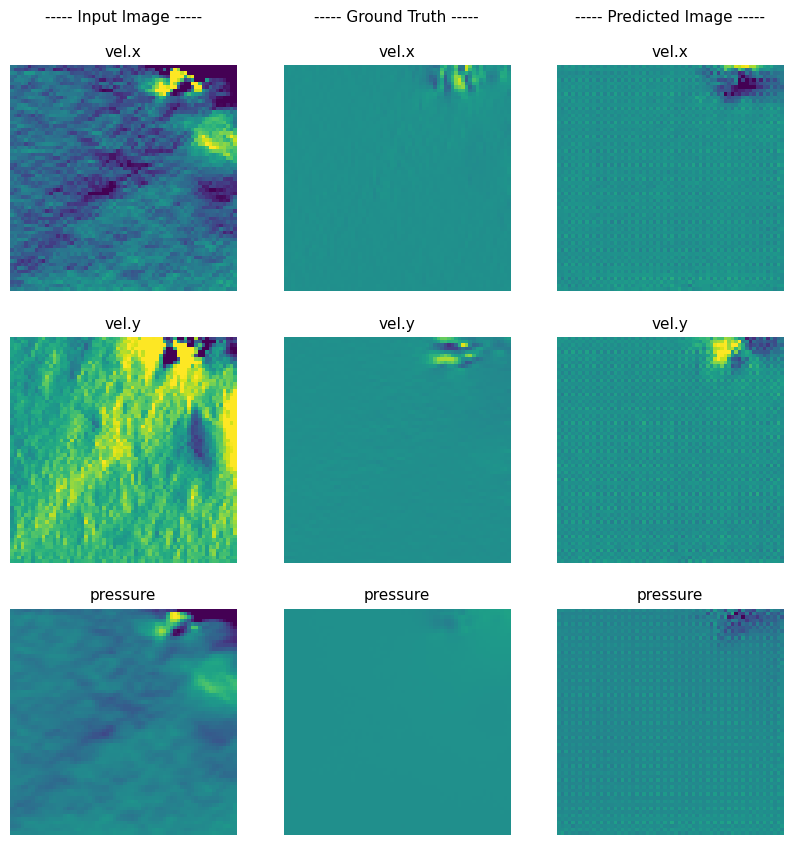

Epoch 95 took 121.37 seconds
Epoch 96, Batch 0:
Generator Loss: 1.3293,  LR: 9.28e-05
Discriminator Loss: 0.1050,  LR: 2.32e-05
Epoch 96, Batch 200:
Generator Loss: 1.9299,  LR: 9.28e-05
Discriminator Loss: 0.0612,  LR: 2.32e-05
Epoch 96, Batch 400:
Generator Loss: 2.2723,  LR: 9.28e-05
Discriminator Loss: 0.1071,  LR: 2.32e-05
Epoch 96, Batch 600:
Generator Loss: 1.2917,  LR: 9.28e-05
Discriminator Loss: 0.0493,  LR: 2.32e-05
Epoch 96 took 120.58 seconds
Epoch 97, Batch 0:
Generator Loss: 1.5576,  LR: 9.28e-05
Discriminator Loss: 0.0388,  LR: 2.32e-05
Epoch 97, Batch 200:
Generator Loss: 2.1531,  LR: 9.28e-05
Discriminator Loss: 0.0194,  LR: 2.32e-05
Epoch 97, Batch 400:
Generator Loss: 2.7267,  LR: 9.28e-05
Discriminator Loss: 0.0146,  LR: 2.32e-05
Epoch 97, Batch 600:
Generator Loss: 1.0109,  LR: 9.28e-05
Discriminator Loss: 0.1466,  LR: 2.32e-05
Epoch 97 took 121.65 seconds
Epoch 98, Batch 0:
Generator Loss: 2.6524,  LR: 9.28e-05
Discriminator Loss: 0.0202,  LR: 2.32e-05
Epoch 98, 

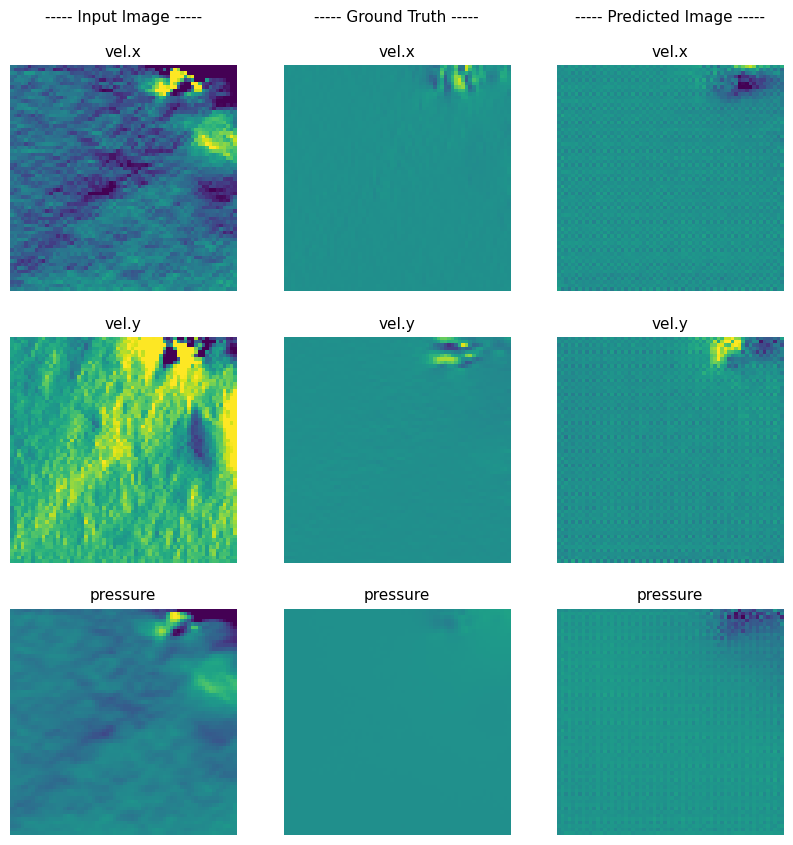

Checkpoint saved for epoch 100
Epoch 100 took 130.76 seconds
Epoch 101, Batch 0:
Generator Loss: 1.2139,  LR: 8.91e-05
Discriminator Loss: 0.0234,  LR: 2.23e-05
Epoch 101, Batch 200:
Generator Loss: 2.7420,  LR: 8.91e-05
Discriminator Loss: 0.0118,  LR: 2.23e-05
Epoch 101, Batch 400:
Generator Loss: 2.4508,  LR: 8.91e-05
Discriminator Loss: 0.0341,  LR: 2.23e-05
Epoch 101, Batch 600:
Generator Loss: 2.5203,  LR: 8.91e-05
Discriminator Loss: 0.0195,  LR: 2.23e-05
Epoch 101 took 119.33 seconds
Epoch 102, Batch 0:
Generator Loss: 1.7440,  LR: 8.91e-05
Discriminator Loss: 0.0093,  LR: 2.23e-05
Epoch 102, Batch 200:
Generator Loss: 1.1051,  LR: 8.91e-05
Discriminator Loss: 0.1382,  LR: 2.23e-05
Epoch 102, Batch 400:
Generator Loss: 2.1907,  LR: 8.91e-05
Discriminator Loss: 0.0109,  LR: 2.23e-05
Epoch 102, Batch 600:
Generator Loss: 2.0356,  LR: 8.91e-05
Discriminator Loss: 0.0090,  LR: 2.23e-05
Epoch 102 took 121.53 seconds
Epoch 103, Batch 0:
Generator Loss: 2.6527,  LR: 8.91e-05
Discrimin

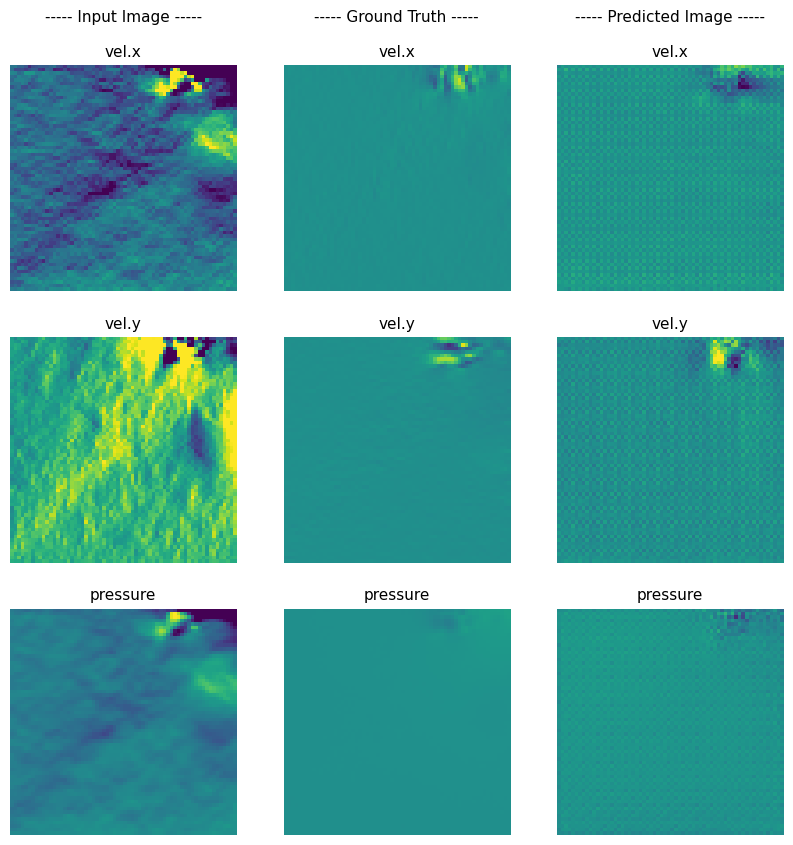

Epoch 105 took 120.94 seconds
Epoch 106, Batch 0:
Generator Loss: 2.3418,  LR: 8.56e-05
Discriminator Loss: 0.0263,  LR: 2.14e-05
Epoch 106, Batch 200:
Generator Loss: 2.3839,  LR: 8.56e-05
Discriminator Loss: 0.0278,  LR: 2.14e-05
Epoch 106, Batch 400:
Generator Loss: 2.1882,  LR: 8.56e-05
Discriminator Loss: 0.0372,  LR: 2.14e-05
Epoch 106, Batch 600:
Generator Loss: 2.5665,  LR: 8.56e-05
Discriminator Loss: 0.0179,  LR: 2.14e-05
Epoch 106 took 120.00 seconds
Epoch 107, Batch 0:
Generator Loss: 1.4452,  LR: 8.56e-05
Discriminator Loss: 0.0923,  LR: 2.14e-05
Epoch 107, Batch 200:
Generator Loss: 1.7993,  LR: 8.56e-05
Discriminator Loss: 0.0672,  LR: 2.14e-05
Epoch 107, Batch 400:
Generator Loss: 1.3834,  LR: 8.56e-05
Discriminator Loss: 0.0311,  LR: 2.14e-05
Epoch 107, Batch 600:
Generator Loss: 1.8488,  LR: 8.56e-05
Discriminator Loss: 0.1553,  LR: 2.14e-05
Epoch 107 took 119.71 seconds
Epoch 108, Batch 0:
Generator Loss: 2.8108,  LR: 8.56e-05
Discriminator Loss: 0.0074,  LR: 2.14e-0

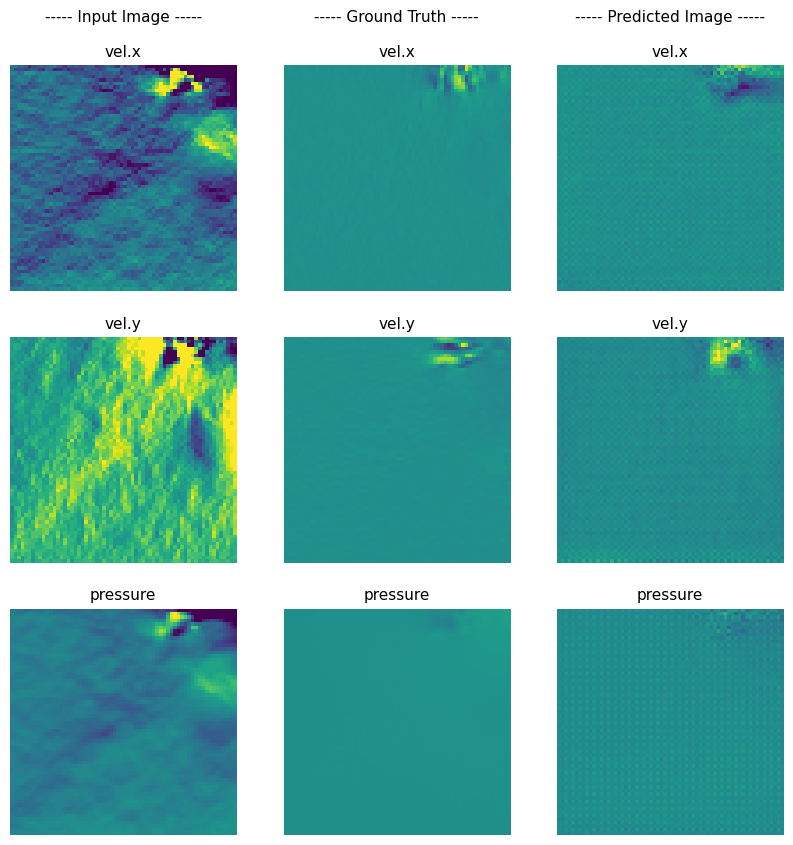

Epoch 110 took 131.57 seconds
Epoch 111, Batch 0:
Generator Loss: 1.3513,  LR: 8.22e-05
Discriminator Loss: 0.1117,  LR: 2.06e-05
Epoch 111, Batch 200:
Generator Loss: 2.8559,  LR: 8.22e-05
Discriminator Loss: 0.0096,  LR: 2.06e-05
Epoch 111, Batch 400:
Generator Loss: 1.1562,  LR: 8.22e-05
Discriminator Loss: 0.1404,  LR: 2.06e-05
Epoch 111, Batch 600:
Generator Loss: 1.2614,  LR: 8.22e-05
Discriminator Loss: 0.0234,  LR: 2.06e-05
Epoch 111 took 123.80 seconds
Epoch 112, Batch 0:
Generator Loss: 2.6574,  LR: 8.22e-05
Discriminator Loss: 0.0094,  LR: 2.06e-05
Epoch 112, Batch 200:
Generator Loss: 1.1811,  LR: 8.22e-05
Discriminator Loss: 0.0223,  LR: 2.06e-05
Epoch 112, Batch 400:
Generator Loss: 2.5864,  LR: 8.22e-05
Discriminator Loss: 0.0049,  LR: 2.06e-05
Epoch 112, Batch 600:
Generator Loss: 2.5234,  LR: 8.22e-05
Discriminator Loss: 0.0088,  LR: 2.06e-05
Epoch 112 took 125.01 seconds
Epoch 113, Batch 0:
Generator Loss: 1.3005,  LR: 8.22e-05
Discriminator Loss: 0.0159,  LR: 2.06e-0

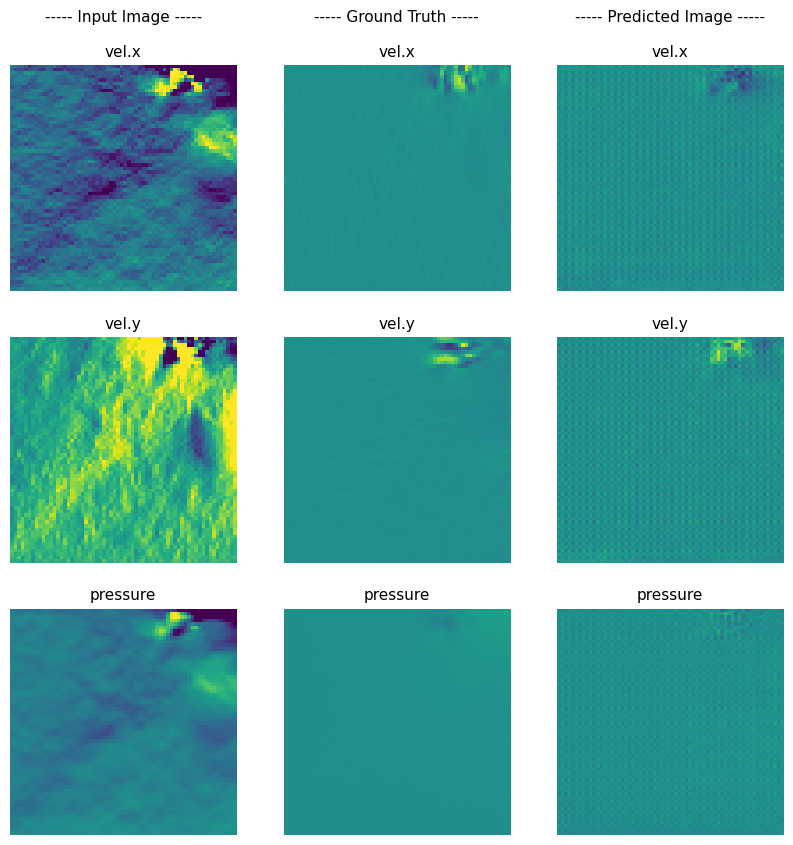

Epoch 115 took 121.69 seconds
Epoch 116, Batch 0:
Generator Loss: 2.6047,  LR: 7.90e-05
Discriminator Loss: 0.1443,  LR: 1.97e-05
Epoch 116, Batch 200:
Generator Loss: 2.5649,  LR: 7.90e-05
Discriminator Loss: 0.0105,  LR: 1.97e-05
Epoch 116, Batch 400:
Generator Loss: 2.1924,  LR: 7.90e-05
Discriminator Loss: 0.1444,  LR: 1.97e-05
Epoch 116, Batch 600:
Generator Loss: 2.5609,  LR: 7.90e-05
Discriminator Loss: 0.0069,  LR: 1.97e-05
Epoch 116 took 119.23 seconds
Epoch 117, Batch 0:
Generator Loss: 2.8311,  LR: 7.90e-05
Discriminator Loss: 0.0046,  LR: 1.97e-05
Epoch 117, Batch 200:
Generator Loss: 2.7447,  LR: 7.90e-05
Discriminator Loss: 0.0056,  LR: 1.97e-05
Epoch 117, Batch 400:
Generator Loss: 2.8223,  LR: 7.90e-05
Discriminator Loss: 0.0078,  LR: 1.97e-05
Epoch 117, Batch 600:
Generator Loss: 2.3042,  LR: 7.90e-05
Discriminator Loss: 0.0906,  LR: 1.97e-05
Epoch 117 took 122.32 seconds
Epoch 118, Batch 0:
Generator Loss: 1.4158,  LR: 7.90e-05
Discriminator Loss: 0.0087,  LR: 1.97e-0

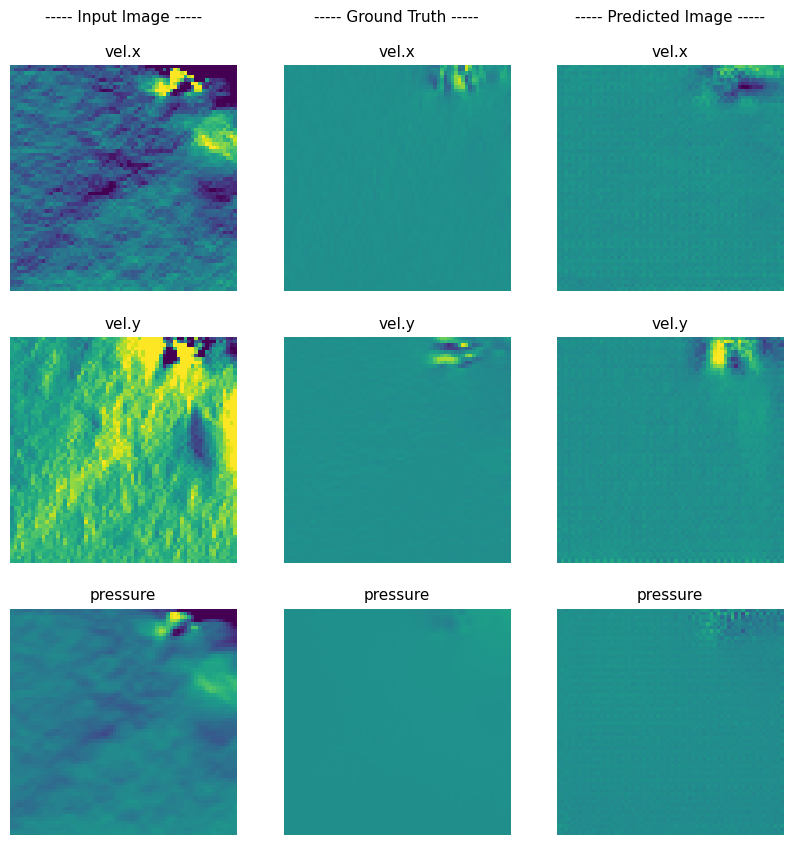

Checkpoint saved for epoch 120
Epoch 120 took 130.26 seconds
Epoch 121, Batch 0:
Generator Loss: 2.8577,  LR: 7.58e-05
Discriminator Loss: 0.0045,  LR: 1.90e-05
Epoch 121, Batch 200:
Generator Loss: 2.6168,  LR: 7.58e-05
Discriminator Loss: 0.0102,  LR: 1.90e-05
Epoch 121, Batch 400:
Generator Loss: 2.6665,  LR: 7.58e-05
Discriminator Loss: 0.0093,  LR: 1.90e-05
Epoch 121, Batch 600:
Generator Loss: 2.6809,  LR: 7.58e-05
Discriminator Loss: 0.0058,  LR: 1.90e-05
Epoch 121 took 120.35 seconds
Epoch 122, Batch 0:
Generator Loss: 2.5044,  LR: 7.58e-05
Discriminator Loss: 0.0098,  LR: 1.90e-05
Epoch 122, Batch 200:
Generator Loss: 2.6294,  LR: 7.58e-05
Discriminator Loss: 0.0055,  LR: 1.90e-05
Epoch 122, Batch 400:
Generator Loss: 3.0126,  LR: 7.58e-05
Discriminator Loss: 0.0064,  LR: 1.90e-05
Epoch 122, Batch 600:
Generator Loss: 2.7872,  LR: 7.58e-05
Discriminator Loss: 0.0178,  LR: 1.90e-05
Epoch 122 took 121.05 seconds
Epoch 123, Batch 0:
Generator Loss: 2.7428,  LR: 7.58e-05
Discrimin

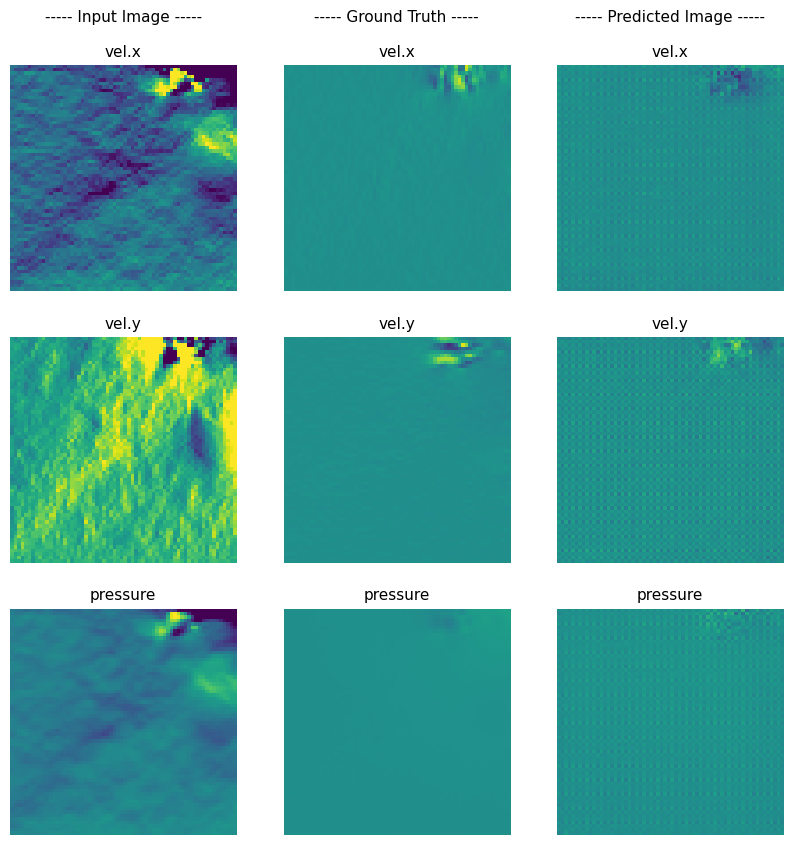

Epoch 125 took 120.91 seconds
Epoch 126, Batch 0:
Generator Loss: 2.6531,  LR: 7.28e-05
Discriminator Loss: 0.0068,  LR: 1.82e-05
Epoch 126, Batch 200:
Generator Loss: 2.7899,  LR: 7.28e-05
Discriminator Loss: 0.0051,  LR: 1.82e-05
Epoch 126, Batch 400:
Generator Loss: 1.3084,  LR: 7.28e-05
Discriminator Loss: 0.0525,  LR: 1.82e-05
Epoch 126, Batch 600:
Generator Loss: 2.6139,  LR: 7.28e-05
Discriminator Loss: 0.0032,  LR: 1.82e-05
Epoch 126 took 121.62 seconds
Epoch 127, Batch 0:
Generator Loss: 2.9532,  LR: 7.28e-05
Discriminator Loss: 0.0210,  LR: 1.82e-05
Epoch 127, Batch 200:
Generator Loss: 2.4165,  LR: 7.28e-05
Discriminator Loss: 0.0115,  LR: 1.82e-05
Epoch 127, Batch 400:
Generator Loss: 2.6007,  LR: 7.28e-05
Discriminator Loss: 0.0110,  LR: 1.82e-05
Epoch 127, Batch 600:
Generator Loss: 1.3923,  LR: 7.28e-05
Discriminator Loss: 0.0162,  LR: 1.82e-05
Epoch 127 took 121.28 seconds
Epoch 128, Batch 0:
Generator Loss: 2.5520,  LR: 7.28e-05
Discriminator Loss: 0.0048,  LR: 1.82e-0

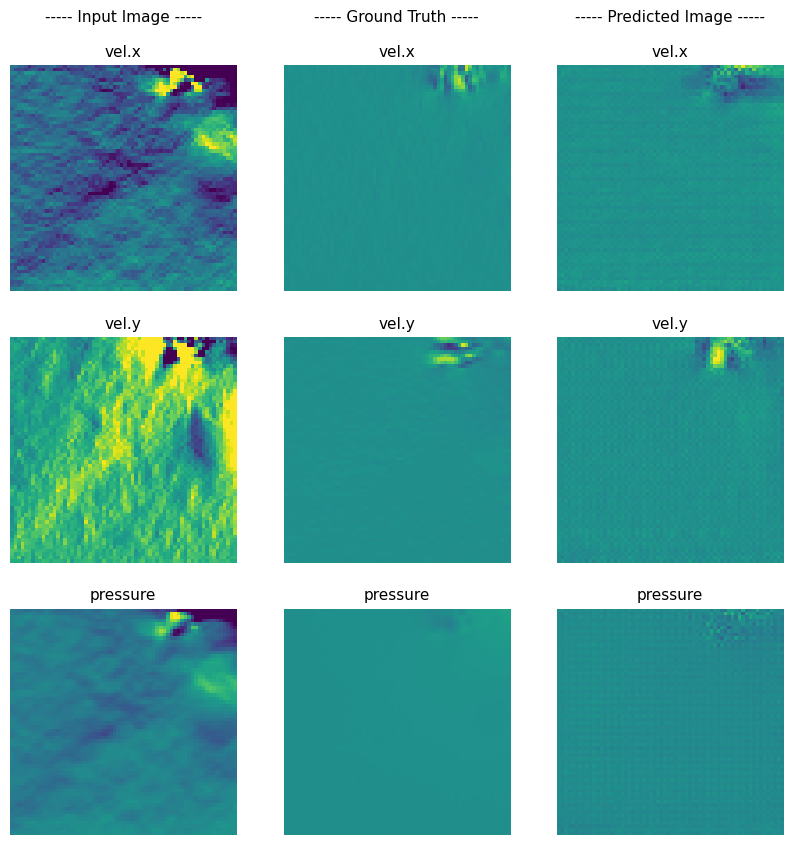

Epoch 130 took 130.74 seconds
Epoch 131, Batch 0:
Generator Loss: 2.7990,  LR: 6.99e-05
Discriminator Loss: 0.0041,  LR: 1.75e-05
Epoch 131, Batch 200:
Generator Loss: 2.6276,  LR: 6.99e-05
Discriminator Loss: 0.0038,  LR: 1.75e-05
Epoch 131, Batch 400:
Generator Loss: 1.4668,  LR: 6.99e-05
Discriminator Loss: 0.0404,  LR: 1.75e-05
Epoch 131, Batch 600:
Generator Loss: 1.8254,  LR: 6.99e-05
Discriminator Loss: 0.1788,  LR: 1.75e-05
Epoch 131 took 121.72 seconds
Epoch 132, Batch 0:
Generator Loss: 1.0634,  LR: 6.99e-05
Discriminator Loss: 0.0095,  LR: 1.75e-05
Epoch 132, Batch 200:
Generator Loss: 1.8588,  LR: 6.99e-05
Discriminator Loss: 0.1414,  LR: 1.75e-05
Epoch 132, Batch 400:
Generator Loss: 2.6114,  LR: 6.99e-05
Discriminator Loss: 0.0034,  LR: 1.75e-05
Epoch 132, Batch 600:
Generator Loss: 1.3018,  LR: 6.99e-05
Discriminator Loss: 0.0101,  LR: 1.75e-05
Epoch 132 took 120.68 seconds
Epoch 133, Batch 0:
Generator Loss: 2.6384,  LR: 6.99e-05
Discriminator Loss: 0.0062,  LR: 1.75e-0

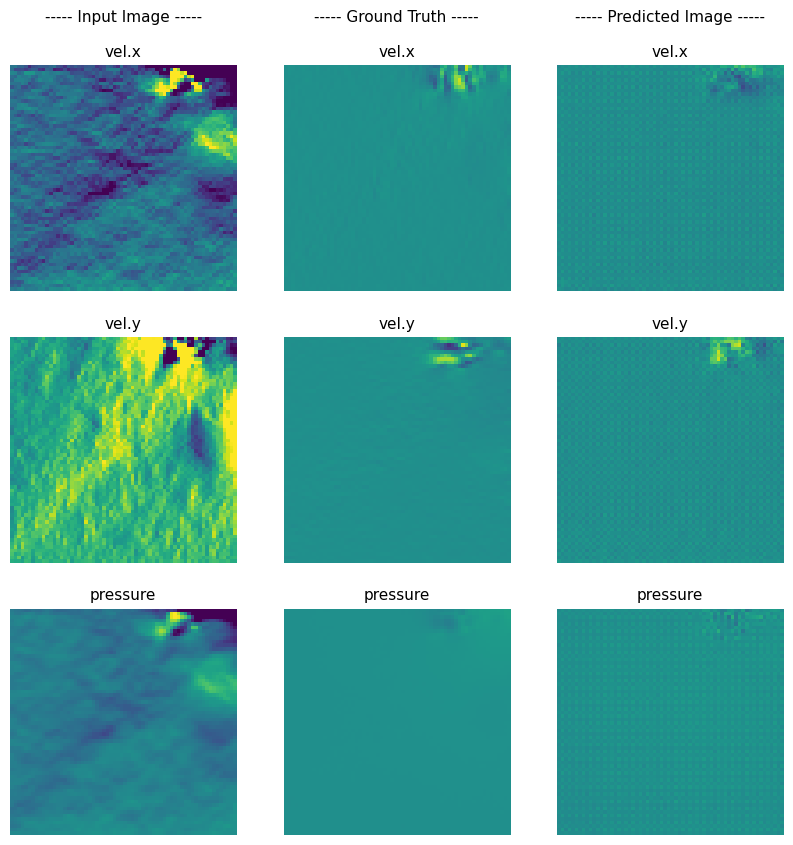

Epoch 135 took 121.10 seconds
Epoch 136, Batch 0:
Generator Loss: 2.5819,  LR: 6.72e-05
Discriminator Loss: 0.0057,  LR: 1.68e-05
Epoch 136, Batch 200:
Generator Loss: 1.2527,  LR: 6.72e-05
Discriminator Loss: 0.0875,  LR: 1.68e-05
Epoch 136, Batch 400:
Generator Loss: 2.6519,  LR: 6.72e-05
Discriminator Loss: 0.0185,  LR: 1.68e-05
Epoch 136, Batch 600:
Generator Loss: 2.2229,  LR: 6.72e-05
Discriminator Loss: 0.0808,  LR: 1.68e-05
Epoch 136 took 120.98 seconds
Epoch 137, Batch 0:
Generator Loss: 2.1496,  LR: 6.72e-05
Discriminator Loss: 0.1436,  LR: 1.68e-05
Epoch 137, Batch 200:
Generator Loss: 1.0764,  LR: 6.72e-05
Discriminator Loss: 0.0746,  LR: 1.68e-05
Epoch 137, Batch 400:
Generator Loss: 1.4608,  LR: 6.72e-05
Discriminator Loss: 0.0179,  LR: 1.68e-05
Epoch 137, Batch 600:
Generator Loss: 1.5505,  LR: 6.72e-05
Discriminator Loss: 0.4325,  LR: 1.68e-05
Epoch 137 took 120.09 seconds
Epoch 138, Batch 0:
Generator Loss: 2.4776,  LR: 6.72e-05
Discriminator Loss: 0.0045,  LR: 1.68e-0

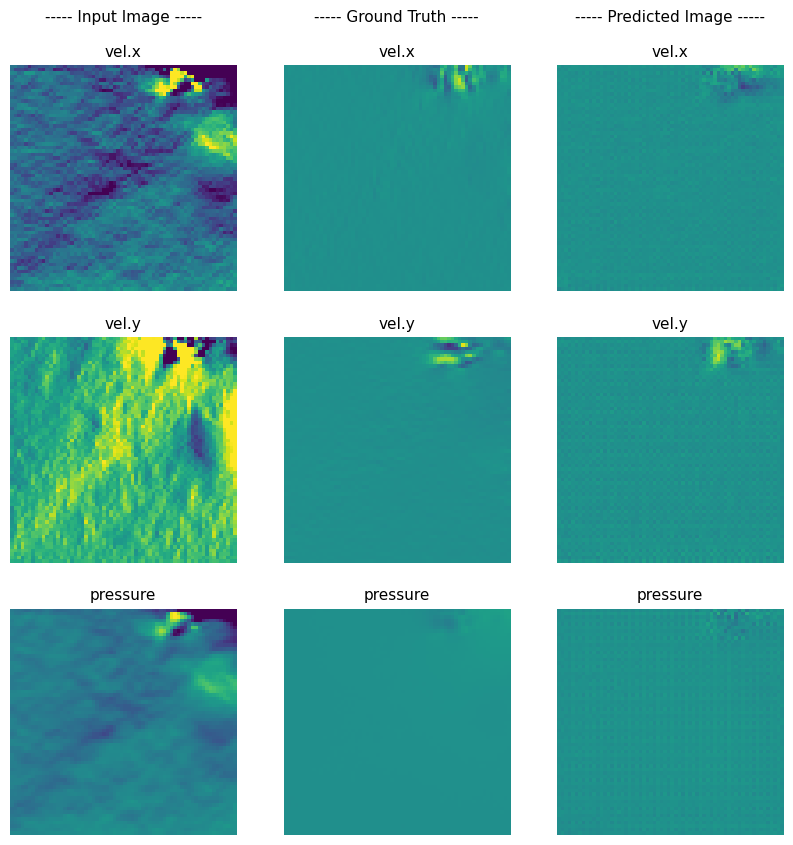

Checkpoint saved for epoch 140
Epoch 140 took 131.42 seconds
Epoch 141, Batch 0:
Generator Loss: 2.5535,  LR: 6.45e-05
Discriminator Loss: 0.0094,  LR: 1.61e-05
Epoch 141, Batch 200:
Generator Loss: 2.5202,  LR: 6.45e-05
Discriminator Loss: 0.0040,  LR: 1.61e-05
Epoch 141, Batch 400:
Generator Loss: 1.6651,  LR: 6.45e-05
Discriminator Loss: 0.0553,  LR: 1.61e-05
Epoch 141, Batch 600:
Generator Loss: 2.1892,  LR: 6.45e-05
Discriminator Loss: 0.1550,  LR: 1.61e-05
Epoch 141 took 121.47 seconds
Epoch 142, Batch 0:
Generator Loss: 1.0731,  LR: 6.45e-05
Discriminator Loss: 0.0080,  LR: 1.61e-05
Epoch 142, Batch 200:
Generator Loss: 2.5212,  LR: 6.45e-05
Discriminator Loss: 0.0047,  LR: 1.61e-05
Epoch 142, Batch 400:
Generator Loss: 1.3477,  LR: 6.45e-05
Discriminator Loss: 0.0161,  LR: 1.61e-05
Epoch 142, Batch 600:
Generator Loss: 2.8364,  LR: 6.45e-05
Discriminator Loss: 0.0038,  LR: 1.61e-05
Epoch 142 took 120.86 seconds
Epoch 143, Batch 0:
Generator Loss: 2.6327,  LR: 6.45e-05
Discrimin

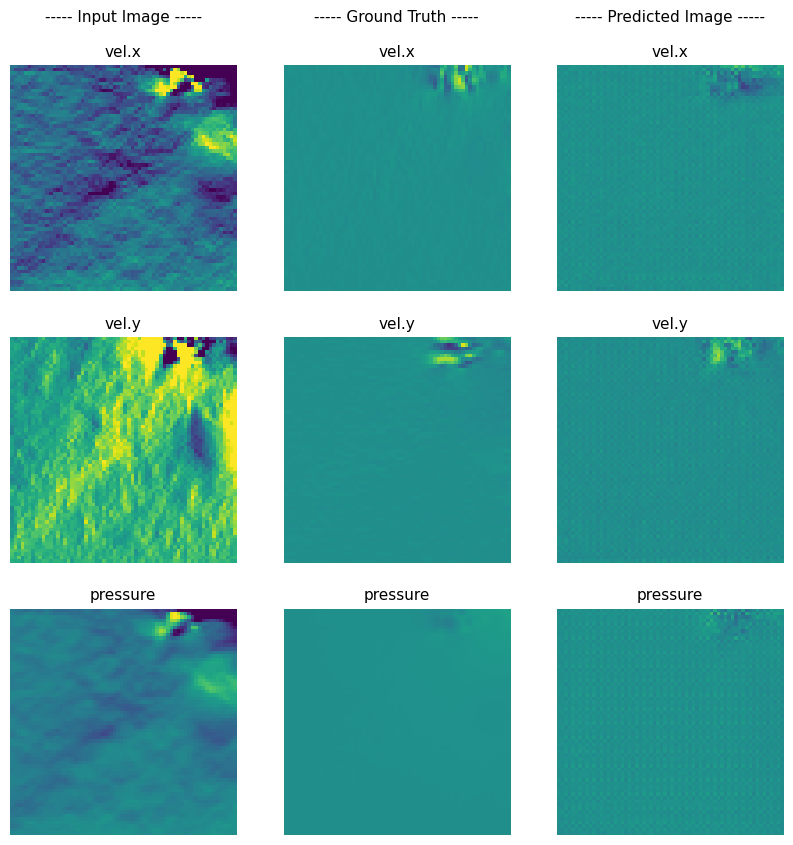

Epoch 145 took 121.36 seconds
Epoch 146, Batch 0:
Generator Loss: 1.6426,  LR: 6.20e-05
Discriminator Loss: 0.0245,  LR: 1.55e-05
Epoch 146, Batch 200:
Generator Loss: 2.5760,  LR: 6.20e-05
Discriminator Loss: 0.0027,  LR: 1.55e-05
Epoch 146, Batch 400:
Generator Loss: 2.5920,  LR: 6.20e-05
Discriminator Loss: 0.0091,  LR: 1.55e-05
Epoch 146, Batch 600:
Generator Loss: 1.1931,  LR: 6.20e-05
Discriminator Loss: 0.0207,  LR: 1.55e-05
Epoch 146 took 121.06 seconds
Epoch 147, Batch 0:
Generator Loss: 1.8334,  LR: 6.20e-05
Discriminator Loss: 0.0922,  LR: 1.55e-05
Epoch 147, Batch 200:
Generator Loss: 2.7133,  LR: 6.20e-05
Discriminator Loss: 0.0059,  LR: 1.55e-05
Epoch 147, Batch 400:
Generator Loss: 1.4400,  LR: 6.20e-05
Discriminator Loss: 0.0232,  LR: 1.55e-05
Epoch 147, Batch 600:
Generator Loss: 1.1225,  LR: 6.20e-05
Discriminator Loss: 0.4586,  LR: 1.55e-05
Epoch 147 took 120.42 seconds
Epoch 148, Batch 0:
Generator Loss: 2.4666,  LR: 6.20e-05
Discriminator Loss: 0.0080,  LR: 1.55e-0

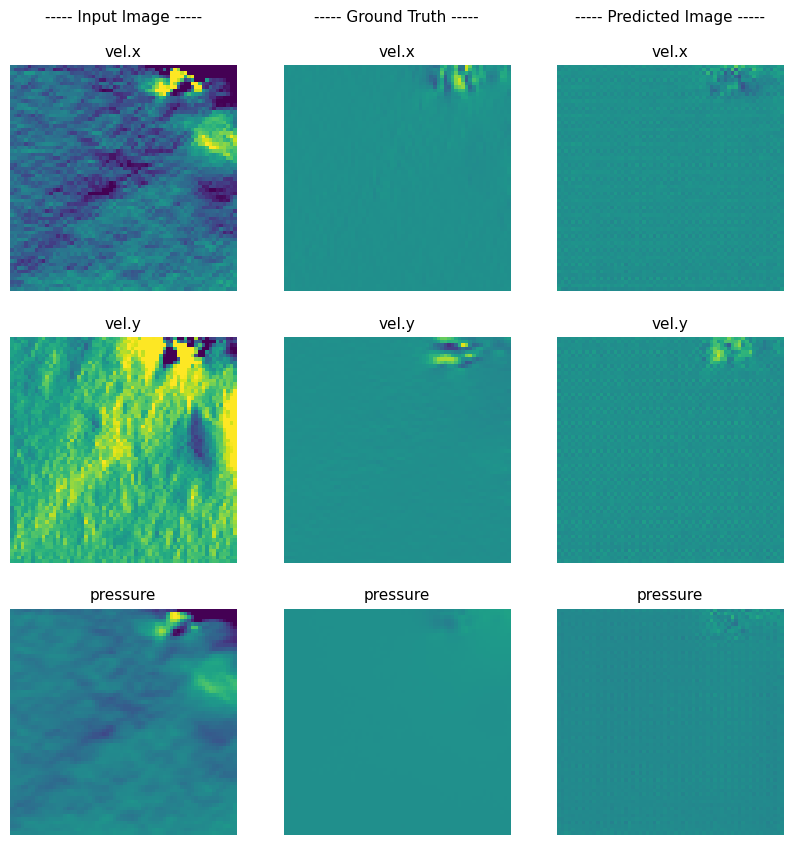

Epoch 150 took 128.39 seconds
Epoch 151, Batch 0:
Generator Loss: 2.6868,  LR: 5.95e-05
Discriminator Loss: 0.0034,  LR: 1.49e-05
Epoch 151, Batch 200:
Generator Loss: 0.8540,  LR: 5.95e-05
Discriminator Loss: 0.3134,  LR: 1.49e-05
Epoch 151, Batch 400:
Generator Loss: 2.7189,  LR: 5.95e-05
Discriminator Loss: 0.0126,  LR: 1.49e-05
Epoch 151, Batch 600:
Generator Loss: 1.3218,  LR: 5.95e-05
Discriminator Loss: 0.0060,  LR: 1.49e-05
Epoch 151 took 121.35 seconds
Epoch 152, Batch 0:
Generator Loss: 2.5093,  LR: 5.95e-05
Discriminator Loss: 0.0044,  LR: 1.49e-05
Epoch 152, Batch 200:
Generator Loss: 2.3603,  LR: 5.95e-05
Discriminator Loss: 0.0060,  LR: 1.49e-05
Epoch 152, Batch 400:
Generator Loss: 1.2025,  LR: 5.95e-05
Discriminator Loss: 0.0116,  LR: 1.49e-05
Epoch 152, Batch 600:
Generator Loss: 2.6625,  LR: 5.95e-05
Discriminator Loss: 0.0073,  LR: 1.49e-05
Epoch 152 took 121.08 seconds
Epoch 153, Batch 0:
Generator Loss: 2.6941,  LR: 5.95e-05
Discriminator Loss: 0.0045,  LR: 1.49e-0

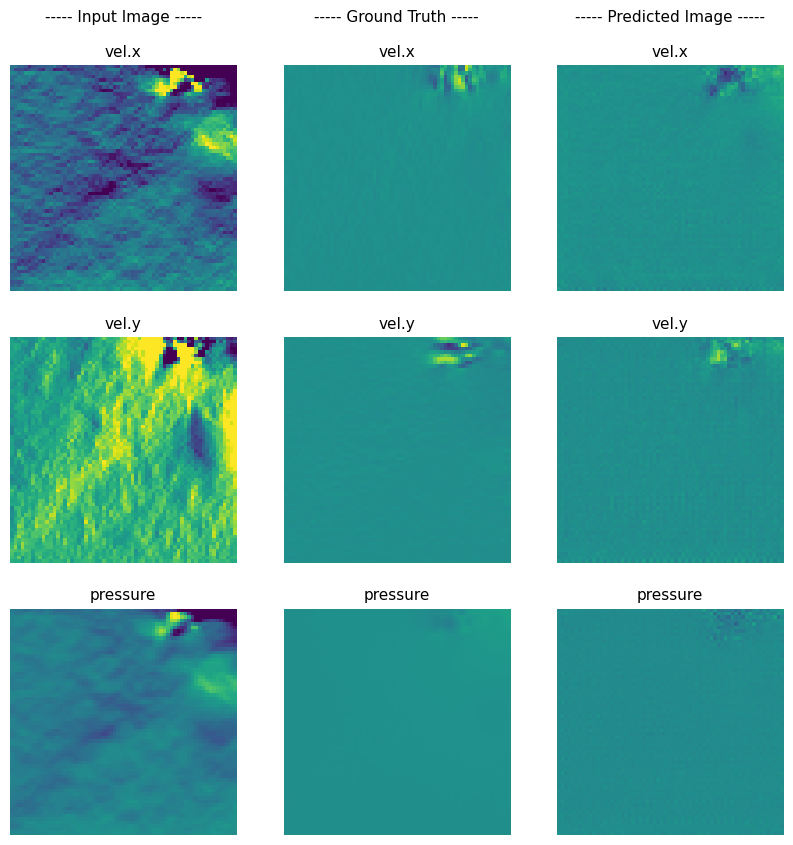

Epoch 155 took 121.96 seconds
Epoch 156, Batch 0:
Generator Loss: 2.5692,  LR: 5.72e-05
Discriminator Loss: 0.0047,  LR: 1.43e-05
Epoch 156, Batch 200:
Generator Loss: 2.5874,  LR: 5.72e-05
Discriminator Loss: 0.0248,  LR: 1.43e-05
Epoch 156, Batch 400:
Generator Loss: 1.0202,  LR: 5.72e-05
Discriminator Loss: 0.0705,  LR: 1.43e-05
Epoch 156, Batch 600:
Generator Loss: 2.6046,  LR: 5.72e-05
Discriminator Loss: 0.0047,  LR: 1.43e-05
Epoch 156 took 121.56 seconds
Epoch 157, Batch 0:
Generator Loss: 2.3892,  LR: 5.72e-05
Discriminator Loss: 0.0572,  LR: 1.43e-05
Epoch 157, Batch 200:
Generator Loss: 1.4828,  LR: 5.72e-05
Discriminator Loss: 0.0799,  LR: 1.43e-05
Epoch 157, Batch 400:
Generator Loss: 1.2860,  LR: 5.72e-05
Discriminator Loss: 0.0083,  LR: 1.43e-05
Epoch 157, Batch 600:
Generator Loss: 1.6921,  LR: 5.72e-05
Discriminator Loss: 0.0305,  LR: 1.43e-05
Epoch 157 took 121.30 seconds
Epoch 158, Batch 0:
Generator Loss: 1.1121,  LR: 5.72e-05
Discriminator Loss: 0.0394,  LR: 1.43e-0

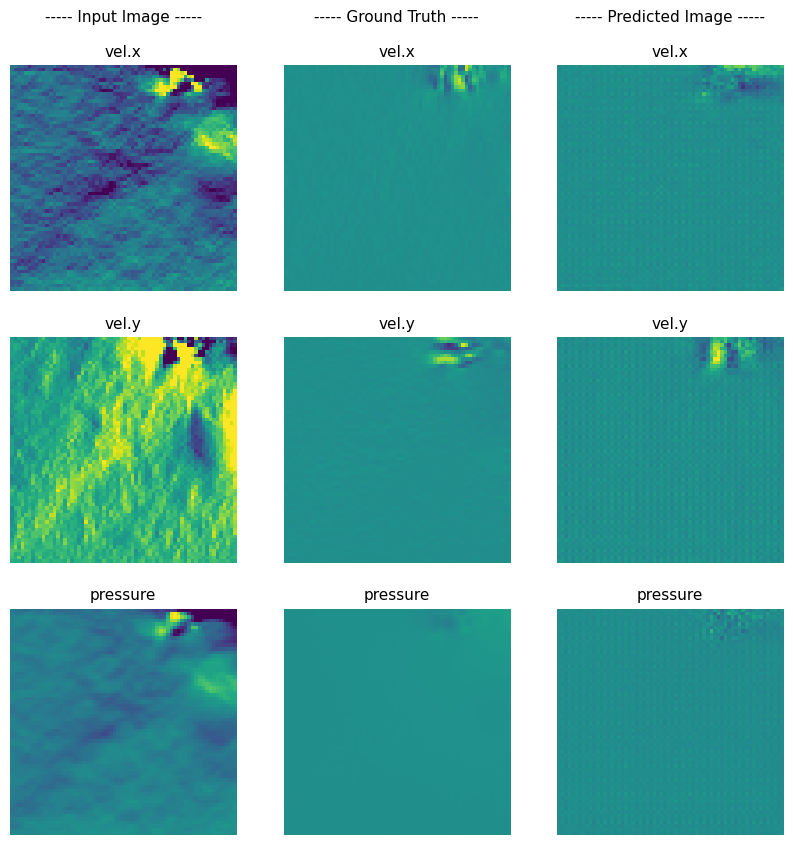

Checkpoint saved for epoch 160
Epoch 160 took 132.07 seconds
Epoch 161, Batch 0:
Generator Loss: 2.6058,  LR: 5.49e-05
Discriminator Loss: 0.0024,  LR: 1.37e-05
Epoch 161, Batch 200:
Generator Loss: 0.7091,  LR: 5.49e-05
Discriminator Loss: 0.5281,  LR: 1.37e-05
Epoch 161, Batch 400:
Generator Loss: 2.7027,  LR: 5.49e-05
Discriminator Loss: 0.0044,  LR: 1.37e-05
Epoch 161, Batch 600:
Generator Loss: 2.5896,  LR: 5.49e-05
Discriminator Loss: 0.0045,  LR: 1.37e-05
Epoch 161 took 121.48 seconds
Epoch 162, Batch 0:
Generator Loss: 2.5517,  LR: 5.49e-05
Discriminator Loss: 0.0184,  LR: 1.37e-05
Epoch 162, Batch 200:
Generator Loss: 1.6766,  LR: 5.49e-05
Discriminator Loss: 0.0031,  LR: 1.37e-05
Epoch 162, Batch 400:
Generator Loss: 2.7226,  LR: 5.49e-05
Discriminator Loss: 0.0061,  LR: 1.37e-05
Epoch 162, Batch 600:
Generator Loss: 0.7462,  LR: 5.49e-05
Discriminator Loss: 0.2229,  LR: 1.37e-05
Epoch 162 took 119.58 seconds
Epoch 163, Batch 0:
Generator Loss: 2.6722,  LR: 5.49e-05
Discrimin

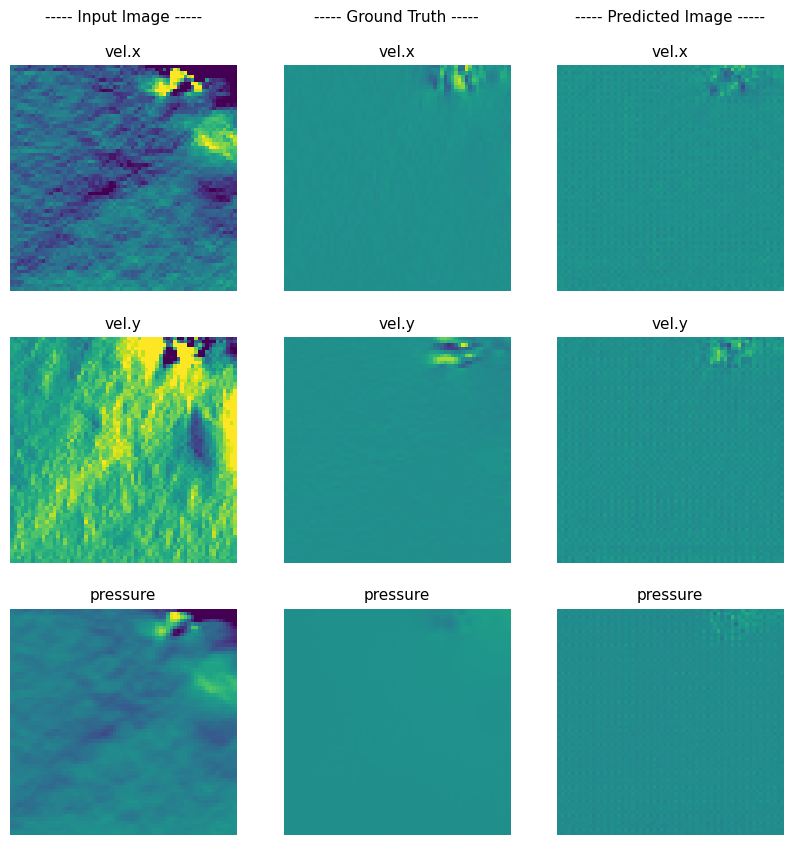

Epoch 165 took 120.96 seconds
Epoch 166, Batch 0:
Generator Loss: 1.1002,  LR: 5.27e-05
Discriminator Loss: 0.0072,  LR: 1.32e-05
Epoch 166, Batch 200:
Generator Loss: 1.4897,  LR: 5.27e-05
Discriminator Loss: 0.0093,  LR: 1.32e-05
Epoch 166, Batch 400:
Generator Loss: 2.7232,  LR: 5.27e-05
Discriminator Loss: 0.0113,  LR: 1.32e-05
Epoch 166, Batch 600:
Generator Loss: 2.3077,  LR: 5.27e-05
Discriminator Loss: 0.1910,  LR: 1.32e-05
Epoch 166 took 120.31 seconds
Epoch 167, Batch 0:
Generator Loss: 2.4256,  LR: 5.27e-05
Discriminator Loss: 0.0071,  LR: 1.32e-05
Epoch 167, Batch 200:
Generator Loss: 2.4807,  LR: 5.27e-05
Discriminator Loss: 0.0105,  LR: 1.32e-05
Epoch 167, Batch 400:
Generator Loss: 2.6048,  LR: 5.27e-05
Discriminator Loss: 0.0039,  LR: 1.32e-05
Epoch 167, Batch 600:
Generator Loss: 2.4084,  LR: 5.27e-05
Discriminator Loss: 0.0062,  LR: 1.32e-05
Epoch 167 took 119.96 seconds
Epoch 168, Batch 0:
Generator Loss: 2.4412,  LR: 5.27e-05
Discriminator Loss: 0.0312,  LR: 1.32e-0

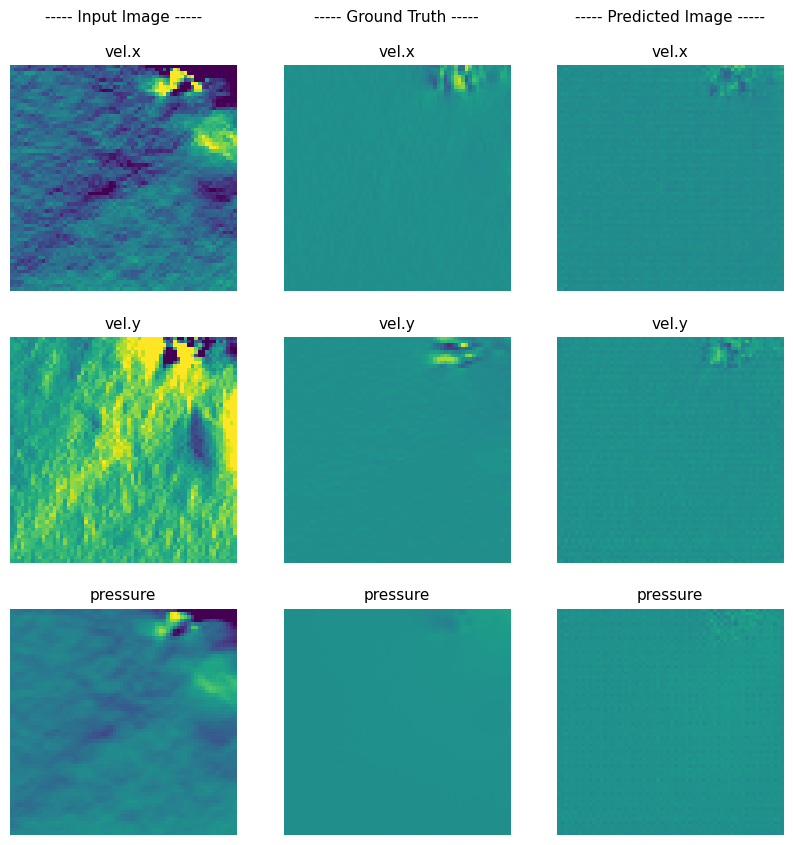

Epoch 170 took 130.37 seconds
Epoch 171, Batch 0:
Generator Loss: 1.0277,  LR: 5.06e-05
Discriminator Loss: 0.1995,  LR: 1.27e-05
Epoch 171, Batch 200:
Generator Loss: 1.1275,  LR: 5.06e-05
Discriminator Loss: 0.4795,  LR: 1.27e-05
Epoch 171, Batch 400:
Generator Loss: 2.6588,  LR: 5.06e-05
Discriminator Loss: 0.0178,  LR: 1.27e-05
Epoch 171, Batch 600:
Generator Loss: 1.2602,  LR: 5.06e-05
Discriminator Loss: 0.3705,  LR: 1.27e-05
Epoch 171 took 120.13 seconds
Epoch 172, Batch 0:
Generator Loss: 2.5774,  LR: 5.06e-05
Discriminator Loss: 0.0073,  LR: 1.27e-05
Epoch 172, Batch 200:
Generator Loss: 2.5367,  LR: 5.06e-05
Discriminator Loss: 0.0062,  LR: 1.27e-05
Epoch 172, Batch 400:
Generator Loss: 2.5447,  LR: 5.06e-05
Discriminator Loss: 0.0101,  LR: 1.27e-05
Epoch 172, Batch 600:
Generator Loss: 2.2023,  LR: 5.06e-05
Discriminator Loss: 0.0407,  LR: 1.27e-05
Epoch 172 took 121.34 seconds
Epoch 173, Batch 0:
Generator Loss: 2.7624,  LR: 5.06e-05
Discriminator Loss: 0.0036,  LR: 1.27e-0

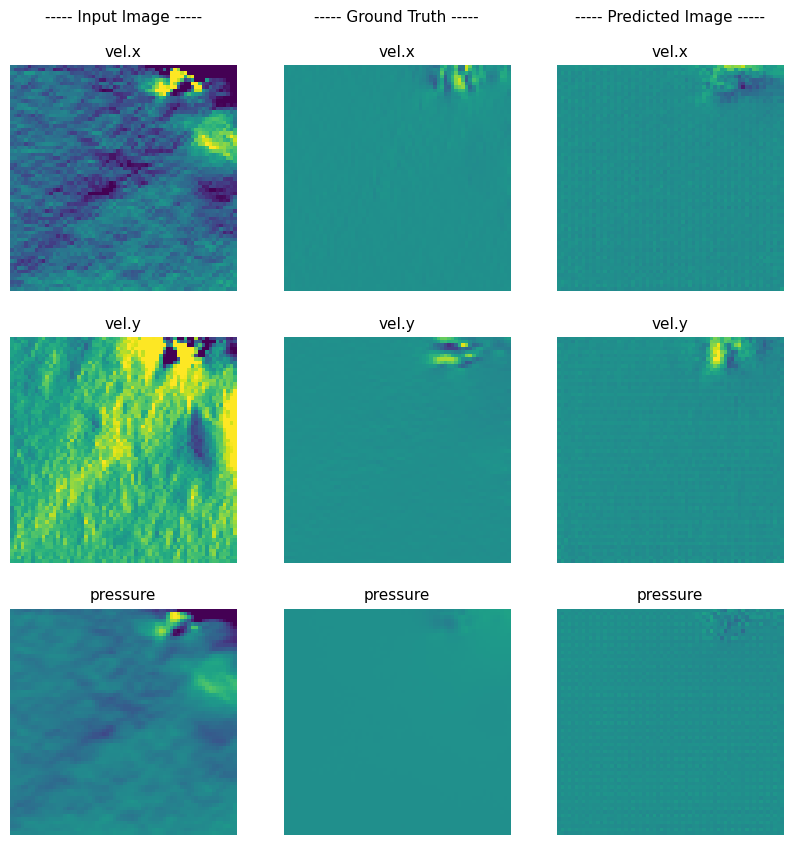

Epoch 175 took 120.94 seconds
Epoch 176, Batch 0:
Generator Loss: 1.2887,  LR: 4.86e-05
Discriminator Loss: 0.0113,  LR: 1.22e-05
Epoch 176, Batch 200:
Generator Loss: 2.4840,  LR: 4.86e-05
Discriminator Loss: 0.0063,  LR: 1.22e-05
Epoch 176, Batch 400:
Generator Loss: 2.4950,  LR: 4.86e-05
Discriminator Loss: 0.0042,  LR: 1.22e-05
Epoch 176, Batch 600:
Generator Loss: 1.4478,  LR: 4.86e-05
Discriminator Loss: 0.2863,  LR: 1.22e-05
Epoch 176 took 121.10 seconds
Epoch 177, Batch 0:
Generator Loss: 2.6042,  LR: 4.86e-05
Discriminator Loss: 0.0188,  LR: 1.22e-05
Epoch 177, Batch 200:
Generator Loss: 1.4393,  LR: 4.86e-05
Discriminator Loss: 0.2893,  LR: 1.22e-05
Epoch 177, Batch 400:
Generator Loss: 1.8742,  LR: 4.86e-05
Discriminator Loss: 0.0034,  LR: 1.22e-05
Epoch 177, Batch 600:
Generator Loss: 0.9191,  LR: 4.86e-05
Discriminator Loss: 0.1526,  LR: 1.22e-05
Epoch 177 took 121.26 seconds
Epoch 178, Batch 0:
Generator Loss: 2.6120,  LR: 4.86e-05
Discriminator Loss: 0.0039,  LR: 1.22e-0

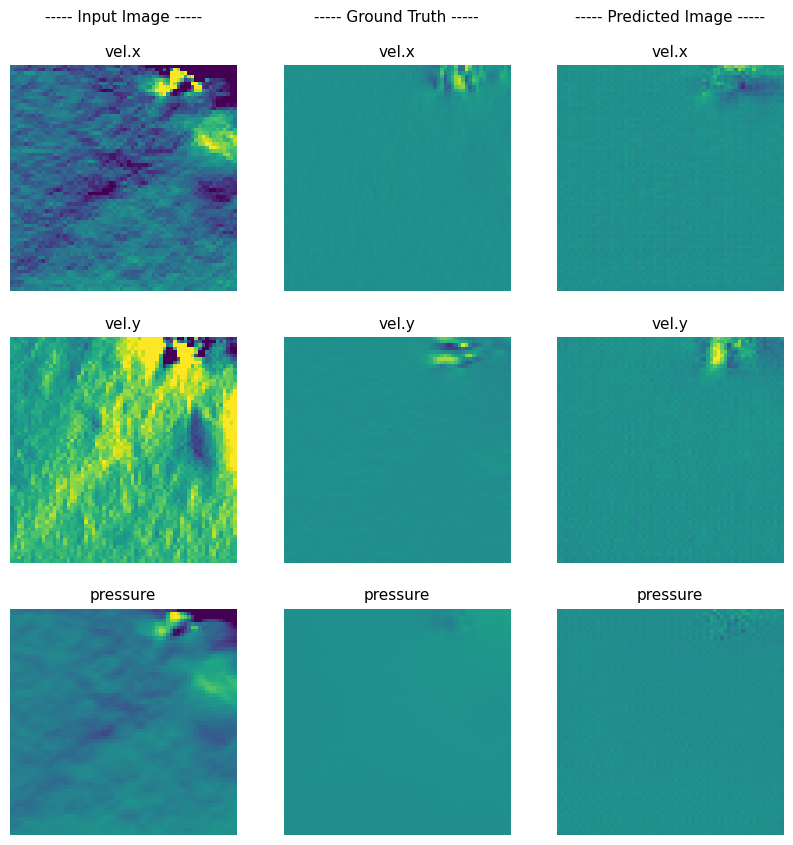

Checkpoint saved for epoch 180
Epoch 180 took 131.08 seconds
Epoch 181, Batch 0:
Generator Loss: 2.5885,  LR: 4.67e-05
Discriminator Loss: 0.0030,  LR: 1.17e-05
Epoch 181, Batch 200:
Generator Loss: 2.5337,  LR: 4.67e-05
Discriminator Loss: 0.0089,  LR: 1.17e-05
Epoch 181, Batch 400:
Generator Loss: 2.5734,  LR: 4.67e-05
Discriminator Loss: 0.0044,  LR: 1.17e-05
Epoch 181, Batch 600:
Generator Loss: 2.4861,  LR: 4.67e-05
Discriminator Loss: 0.0061,  LR: 1.17e-05
Epoch 181 took 120.64 seconds
Epoch 182, Batch 0:
Generator Loss: 2.6695,  LR: 4.67e-05
Discriminator Loss: 0.0107,  LR: 1.17e-05
Epoch 182, Batch 200:
Generator Loss: 2.6531,  LR: 4.67e-05
Discriminator Loss: 0.0027,  LR: 1.17e-05
Epoch 182, Batch 400:
Generator Loss: 0.9151,  LR: 4.67e-05
Discriminator Loss: 0.1408,  LR: 1.17e-05
Epoch 182, Batch 600:
Generator Loss: 2.5082,  LR: 4.67e-05
Discriminator Loss: 0.0061,  LR: 1.17e-05
Epoch 182 took 120.74 seconds
Epoch 183, Batch 0:
Generator Loss: 2.6209,  LR: 4.67e-05
Discrimin

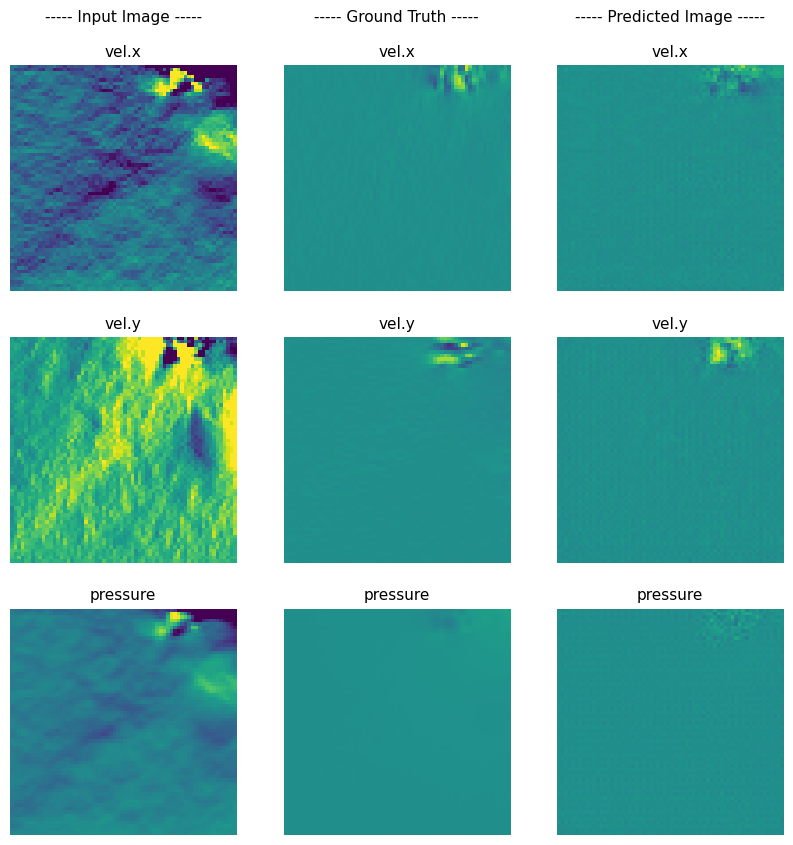

Epoch 185 took 121.42 seconds
Epoch 186, Batch 0:
Generator Loss: 2.5551,  LR: 4.48e-05
Discriminator Loss: 0.0909,  LR: 1.12e-05
Epoch 186, Batch 200:
Generator Loss: 2.5618,  LR: 4.48e-05
Discriminator Loss: 0.0046,  LR: 1.12e-05
Epoch 186, Batch 400:
Generator Loss: 2.5674,  LR: 4.48e-05
Discriminator Loss: 0.0044,  LR: 1.12e-05
Epoch 186, Batch 600:
Generator Loss: 2.3504,  LR: 4.48e-05
Discriminator Loss: 0.0193,  LR: 1.12e-05
Epoch 186 took 121.65 seconds
Epoch 187, Batch 0:
Generator Loss: 2.1464,  LR: 4.48e-05
Discriminator Loss: 0.0119,  LR: 1.12e-05
Epoch 187, Batch 200:
Generator Loss: 2.5101,  LR: 4.48e-05
Discriminator Loss: 0.0051,  LR: 1.12e-05
Epoch 187, Batch 400:
Generator Loss: 0.8409,  LR: 4.48e-05
Discriminator Loss: 0.4261,  LR: 1.12e-05
Epoch 187, Batch 600:
Generator Loss: 1.3999,  LR: 4.48e-05
Discriminator Loss: 0.2097,  LR: 1.12e-05
Epoch 187 took 121.28 seconds
Epoch 188, Batch 0:
Generator Loss: 0.9750,  LR: 4.48e-05
Discriminator Loss: 0.3637,  LR: 1.12e-0

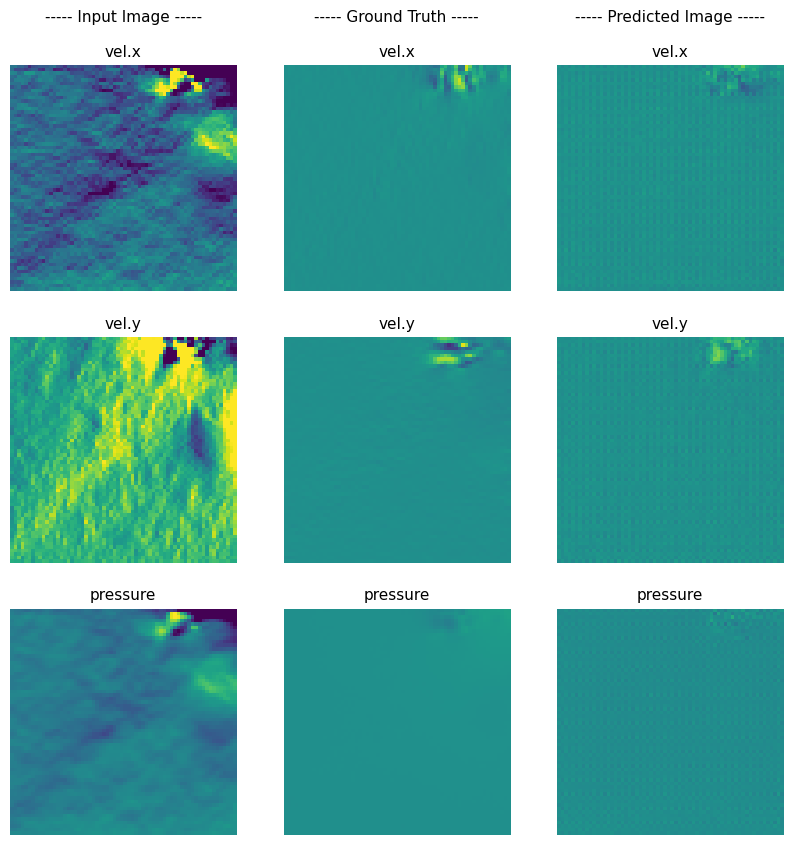

Epoch 190 took 130.32 seconds
Epoch 191, Batch 0:
Generator Loss: 2.7116,  LR: 4.31e-05
Discriminator Loss: 0.0074,  LR: 1.08e-05
Epoch 191, Batch 200:
Generator Loss: 0.7910,  LR: 4.31e-05
Discriminator Loss: 0.1760,  LR: 1.08e-05
Epoch 191, Batch 400:
Generator Loss: 2.6657,  LR: 4.31e-05
Discriminator Loss: 0.0107,  LR: 1.08e-05
Epoch 191, Batch 600:
Generator Loss: 2.5892,  LR: 4.31e-05
Discriminator Loss: 0.0066,  LR: 1.08e-05
Epoch 191 took 121.12 seconds
Epoch 192, Batch 0:
Generator Loss: 1.1616,  LR: 4.31e-05
Discriminator Loss: 0.0398,  LR: 1.08e-05
Epoch 192, Batch 200:
Generator Loss: 1.4941,  LR: 4.31e-05
Discriminator Loss: 0.0080,  LR: 1.08e-05
Epoch 192, Batch 400:
Generator Loss: 2.3591,  LR: 4.31e-05
Discriminator Loss: 0.0069,  LR: 1.08e-05
Epoch 192, Batch 600:
Generator Loss: 2.6303,  LR: 4.31e-05
Discriminator Loss: 0.0051,  LR: 1.08e-05
Epoch 192 took 121.50 seconds
Epoch 193, Batch 0:
Generator Loss: 1.4251,  LR: 4.31e-05
Discriminator Loss: 0.0051,  LR: 1.08e-0

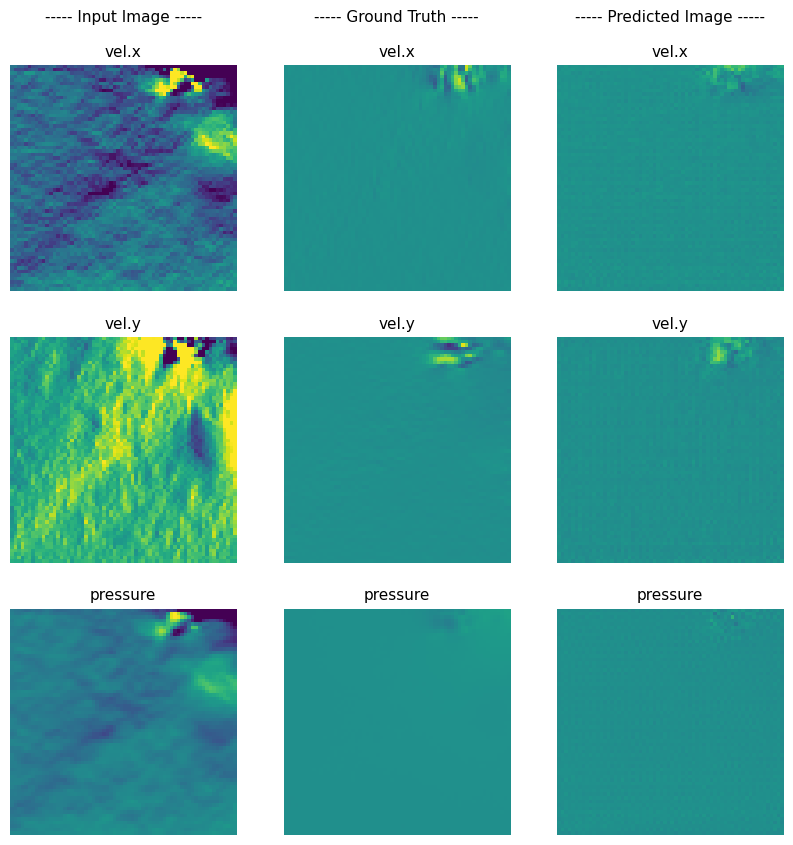

Epoch 195 took 121.80 seconds
Epoch 196, Batch 0:
Generator Loss: 0.7989,  LR: 4.14e-05
Discriminator Loss: 0.1802,  LR: 1.03e-05
Epoch 196, Batch 200:
Generator Loss: 0.9012,  LR: 4.14e-05
Discriminator Loss: 0.4554,  LR: 1.03e-05
Epoch 196, Batch 400:
Generator Loss: 1.8792,  LR: 4.14e-05
Discriminator Loss: 0.0179,  LR: 1.03e-05
Epoch 196, Batch 600:
Generator Loss: 2.5447,  LR: 4.14e-05
Discriminator Loss: 0.0053,  LR: 1.03e-05
Epoch 196 took 120.26 seconds
Epoch 197, Batch 0:
Generator Loss: 0.8227,  LR: 4.14e-05
Discriminator Loss: 0.2006,  LR: 1.03e-05
Epoch 197, Batch 200:
Generator Loss: 2.2317,  LR: 4.14e-05
Discriminator Loss: 0.0066,  LR: 1.03e-05
Epoch 197, Batch 400:
Generator Loss: 2.2317,  LR: 4.14e-05
Discriminator Loss: 0.0178,  LR: 1.03e-05
Epoch 197, Batch 600:
Generator Loss: 0.9839,  LR: 4.14e-05
Discriminator Loss: 0.0142,  LR: 1.03e-05
Epoch 197 took 120.57 seconds
Epoch 198, Batch 0:
Generator Loss: 2.5396,  LR: 4.14e-05
Discriminator Loss: 0.0085,  LR: 1.03e-0

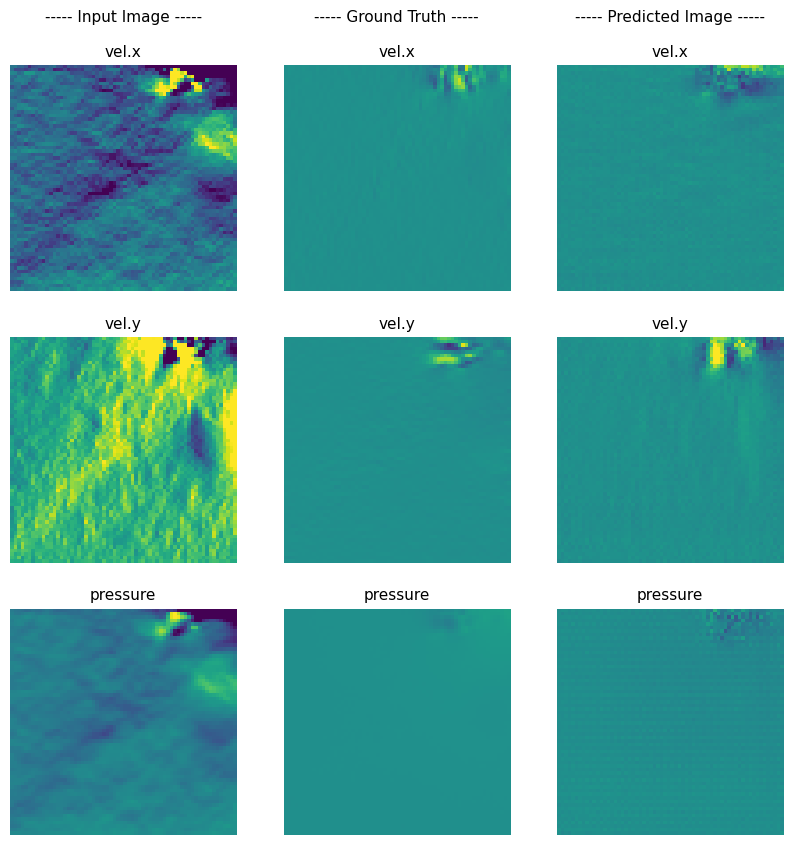

Checkpoint saved for epoch 200
Epoch 200 took 132.05 seconds
Epoch 201, Batch 0:
Generator Loss: 2.6182,  LR: 3.97e-05
Discriminator Loss: 0.0044,  LR: 9.93e-06
Epoch 201, Batch 200:
Generator Loss: 2.3401,  LR: 3.97e-05
Discriminator Loss: 0.0118,  LR: 9.93e-06
Epoch 201, Batch 400:
Generator Loss: 2.5024,  LR: 3.97e-05
Discriminator Loss: 0.0048,  LR: 9.93e-06
Epoch 201, Batch 600:
Generator Loss: 1.0937,  LR: 3.97e-05
Discriminator Loss: 0.0063,  LR: 9.93e-06
Epoch 201 took 121.12 seconds
Epoch 202, Batch 0:
Generator Loss: 0.7762,  LR: 3.97e-05
Discriminator Loss: 0.2996,  LR: 9.93e-06
Epoch 202, Batch 200:
Generator Loss: 2.6091,  LR: 3.97e-05
Discriminator Loss: 0.0027,  LR: 9.93e-06
Epoch 202, Batch 400:
Generator Loss: 2.4027,  LR: 3.97e-05
Discriminator Loss: 0.0134,  LR: 9.93e-06
Epoch 202, Batch 600:
Generator Loss: 1.8509,  LR: 3.97e-05
Discriminator Loss: 0.1739,  LR: 9.93e-06
Epoch 202 took 121.40 seconds
Epoch 203, Batch 0:
Generator Loss: 2.4652,  LR: 3.97e-05
Discrimin

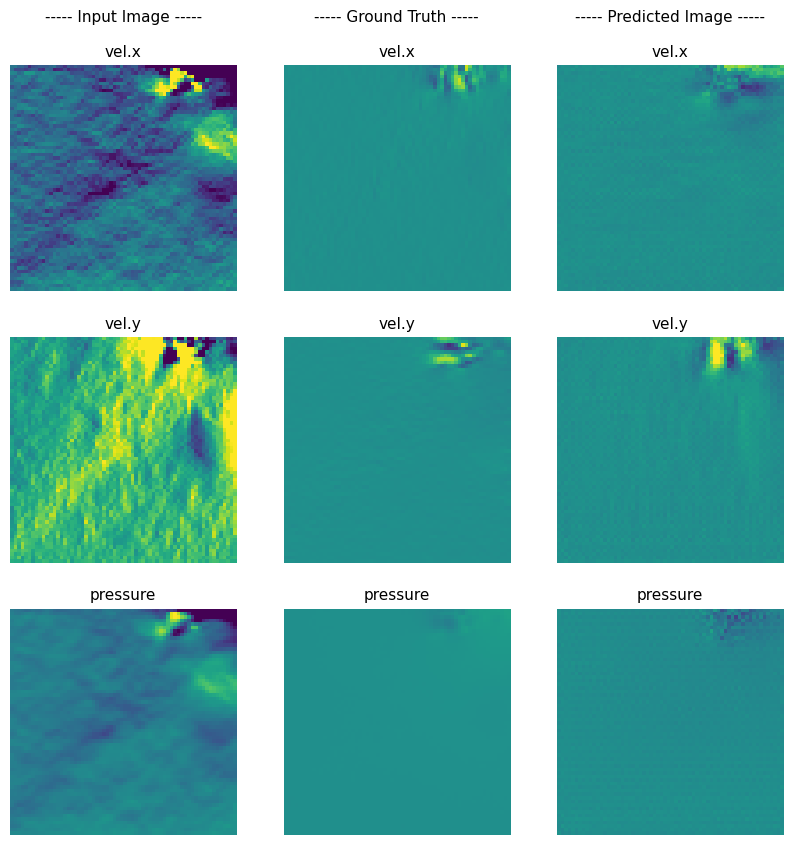

Epoch 205 took 122.40 seconds
Epoch 206, Batch 0:
Generator Loss: 2.1694,  LR: 3.82e-05
Discriminator Loss: 0.0854,  LR: 9.54e-06
Epoch 206, Batch 200:
Generator Loss: 0.6913,  LR: 3.82e-05
Discriminator Loss: 0.2735,  LR: 9.54e-06
Epoch 206, Batch 400:
Generator Loss: 1.1075,  LR: 3.82e-05
Discriminator Loss: 0.0128,  LR: 9.54e-06
Epoch 206, Batch 600:
Generator Loss: 0.9018,  LR: 3.82e-05
Discriminator Loss: 0.6688,  LR: 9.54e-06
Epoch 206 took 120.87 seconds
Epoch 207, Batch 0:
Generator Loss: 0.6745,  LR: 3.82e-05
Discriminator Loss: 0.1508,  LR: 9.54e-06
Epoch 207, Batch 200:
Generator Loss: 1.0656,  LR: 3.82e-05
Discriminator Loss: 0.0108,  LR: 9.54e-06
Epoch 207, Batch 400:
Generator Loss: 2.4382,  LR: 3.82e-05
Discriminator Loss: 0.0039,  LR: 9.54e-06
Epoch 207, Batch 600:
Generator Loss: 2.6478,  LR: 3.82e-05
Discriminator Loss: 0.0067,  LR: 9.54e-06
Epoch 207 took 120.23 seconds
Epoch 208, Batch 0:
Generator Loss: 2.5747,  LR: 3.82e-05
Discriminator Loss: 0.0025,  LR: 9.54e-0

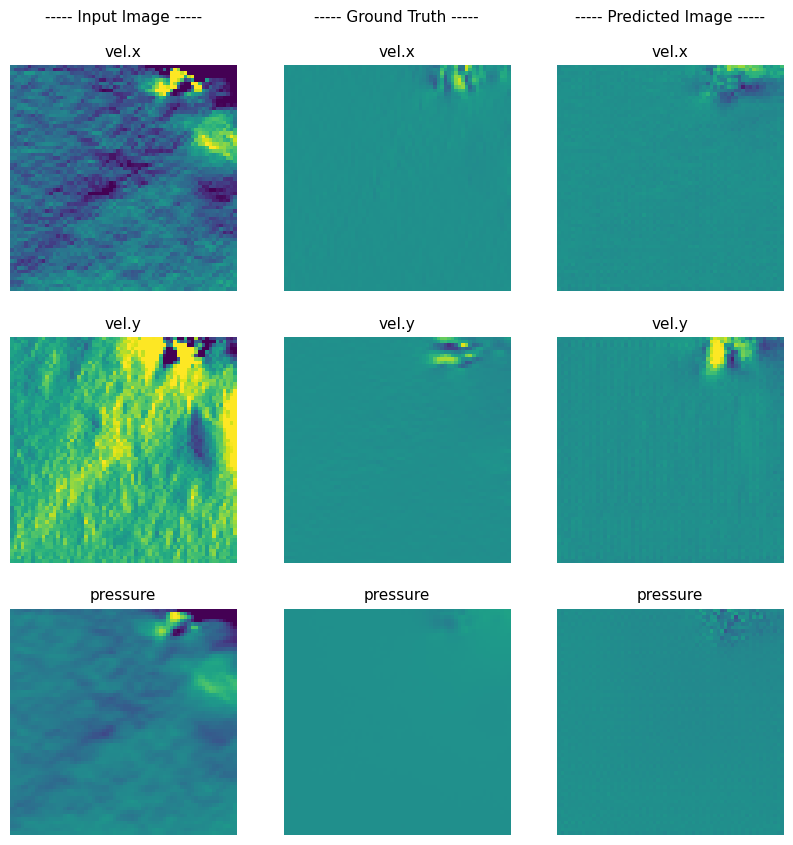

Epoch 210 took 129.82 seconds
Epoch 211, Batch 0:
Generator Loss: 2.3718,  LR: 3.66e-05
Discriminator Loss: 0.0065,  LR: 9.16e-06
Epoch 211, Batch 200:
Generator Loss: 2.6200,  LR: 3.66e-05
Discriminator Loss: 0.0060,  LR: 9.16e-06
Epoch 211, Batch 400:
Generator Loss: 1.0741,  LR: 3.66e-05
Discriminator Loss: 0.0349,  LR: 9.16e-06
Epoch 211, Batch 600:
Generator Loss: 1.5592,  LR: 3.66e-05
Discriminator Loss: 0.2388,  LR: 9.16e-06
Epoch 211 took 121.11 seconds
Epoch 212, Batch 0:
Generator Loss: 1.7556,  LR: 3.66e-05
Discriminator Loss: 0.2570,  LR: 9.16e-06
Epoch 212, Batch 200:
Generator Loss: 1.1543,  LR: 3.66e-05
Discriminator Loss: 0.0045,  LR: 9.16e-06
Epoch 212, Batch 400:
Generator Loss: 2.3460,  LR: 3.66e-05
Discriminator Loss: 0.0034,  LR: 9.16e-06
Epoch 212, Batch 600:
Generator Loss: 2.4586,  LR: 3.66e-05
Discriminator Loss: 0.0063,  LR: 9.16e-06
Epoch 212 took 120.99 seconds
Epoch 213, Batch 0:
Generator Loss: 1.0660,  LR: 3.66e-05
Discriminator Loss: 0.0155,  LR: 9.16e-0

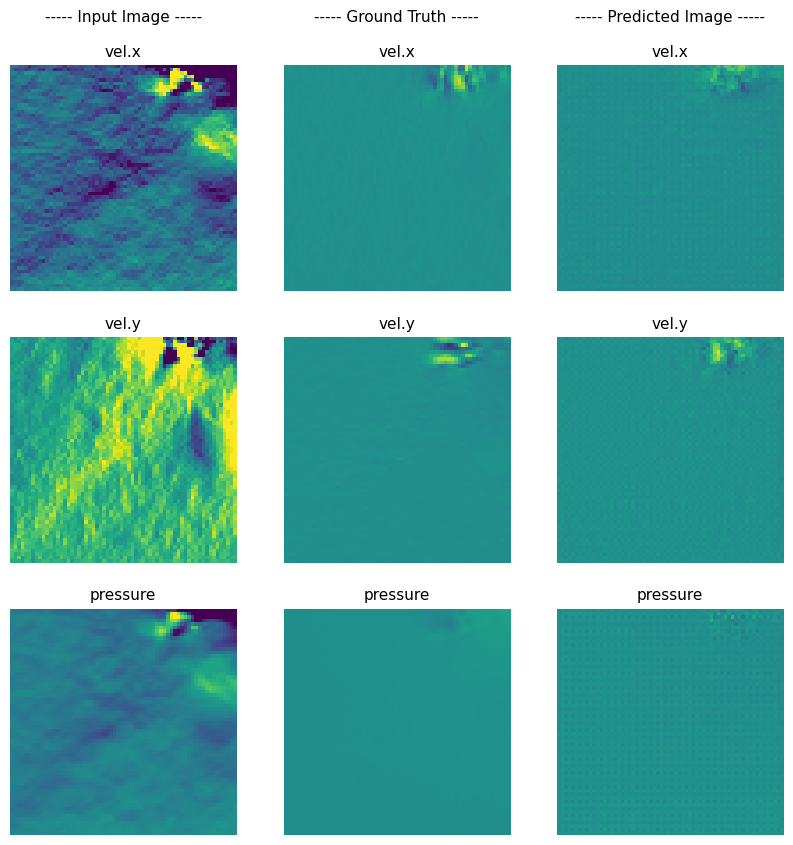

Epoch 215 took 126.42 seconds
Epoch 216, Batch 0:
Generator Loss: 1.1945,  LR: 3.52e-05
Discriminator Loss: 0.0119,  LR: 8.80e-06
Epoch 216, Batch 200:
Generator Loss: 2.5997,  LR: 3.52e-05
Discriminator Loss: 0.0110,  LR: 8.80e-06
Epoch 216, Batch 400:
Generator Loss: 1.3498,  LR: 3.52e-05
Discriminator Loss: 0.0057,  LR: 8.80e-06
Epoch 216, Batch 600:
Generator Loss: 1.0885,  LR: 3.52e-05
Discriminator Loss: 0.0317,  LR: 8.80e-06
Epoch 216 took 122.90 seconds
Epoch 217, Batch 0:
Generator Loss: 2.4620,  LR: 3.52e-05
Discriminator Loss: 0.0045,  LR: 8.80e-06
Epoch 217, Batch 200:
Generator Loss: 2.3986,  LR: 3.52e-05
Discriminator Loss: 0.0070,  LR: 8.80e-06
Epoch 217, Batch 400:
Generator Loss: 0.7063,  LR: 3.52e-05
Discriminator Loss: 0.2715,  LR: 8.80e-06
Epoch 217, Batch 600:
Generator Loss: 0.9871,  LR: 3.52e-05
Discriminator Loss: 0.0368,  LR: 8.80e-06
Epoch 217 took 118.55 seconds
Epoch 218, Batch 0:
Generator Loss: 2.5312,  LR: 3.52e-05
Discriminator Loss: 0.0034,  LR: 8.80e-0

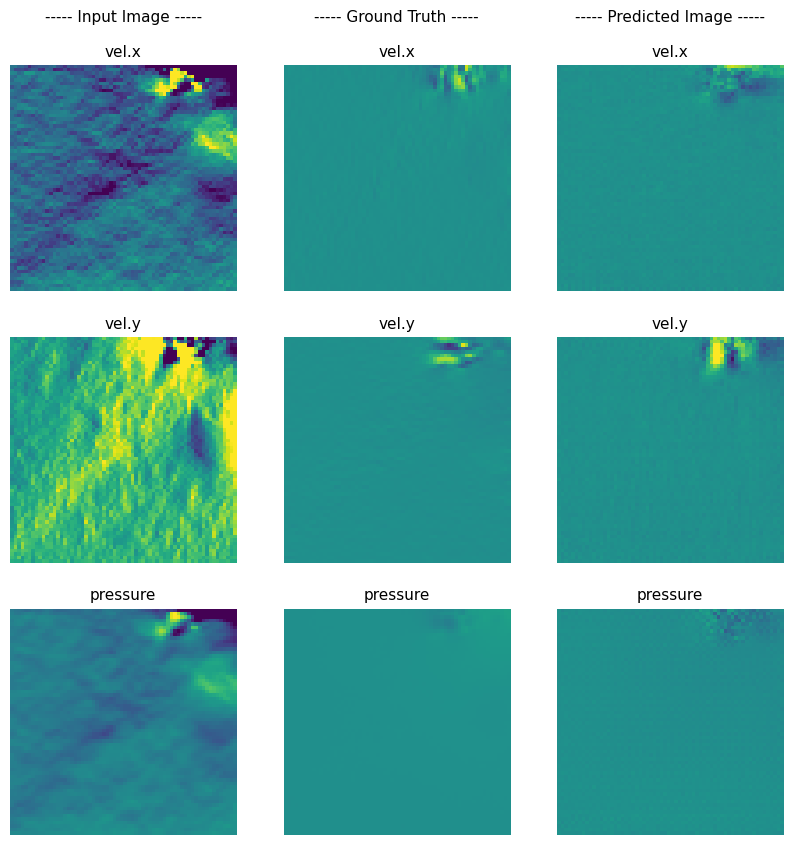

Checkpoint saved for epoch 220
Epoch 220 took 135.14 seconds
Epoch 221, Batch 0:
Generator Loss: 0.7664,  LR: 3.38e-05
Discriminator Loss: 0.1335,  LR: 8.45e-06
Epoch 221, Batch 200:
Generator Loss: 1.3502,  LR: 3.38e-05
Discriminator Loss: 0.0070,  LR: 8.45e-06
Epoch 221, Batch 400:
Generator Loss: 1.1258,  LR: 3.38e-05
Discriminator Loss: 0.1217,  LR: 8.45e-06
Epoch 221, Batch 600:
Generator Loss: 0.8439,  LR: 3.38e-05
Discriminator Loss: 0.1653,  LR: 8.45e-06
Epoch 221 took 121.58 seconds
Epoch 222, Batch 0:
Generator Loss: 2.3883,  LR: 3.38e-05
Discriminator Loss: 0.0176,  LR: 8.45e-06
Epoch 222, Batch 200:
Generator Loss: 0.8847,  LR: 3.38e-05
Discriminator Loss: 0.0346,  LR: 8.45e-06
Epoch 222, Batch 400:
Generator Loss: 2.6308,  LR: 3.38e-05
Discriminator Loss: 0.0204,  LR: 8.45e-06
Epoch 222, Batch 600:
Generator Loss: 2.0605,  LR: 3.38e-05
Discriminator Loss: 0.1075,  LR: 8.45e-06
Epoch 222 took 118.06 seconds
Epoch 223, Batch 0:
Generator Loss: 2.5755,  LR: 3.38e-05
Discrimin

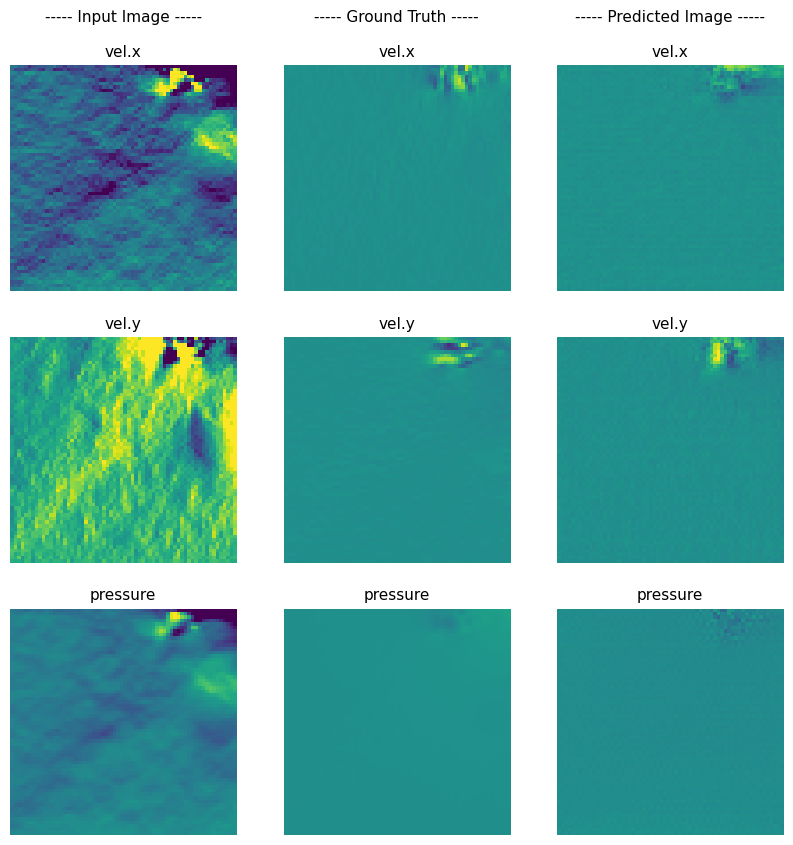

Epoch 225 took 126.08 seconds
Epoch 226, Batch 0:
Generator Loss: 2.3062,  LR: 3.25e-05
Discriminator Loss: 0.0211,  LR: 8.12e-06
Epoch 226, Batch 200:
Generator Loss: 2.5802,  LR: 3.25e-05
Discriminator Loss: 0.0074,  LR: 8.12e-06
Epoch 226, Batch 400:
Generator Loss: 2.4845,  LR: 3.25e-05
Discriminator Loss: 0.0050,  LR: 8.12e-06
Epoch 226, Batch 600:
Generator Loss: 1.1233,  LR: 3.25e-05
Discriminator Loss: 0.0097,  LR: 8.12e-06
Epoch 226 took 123.22 seconds
Epoch 227, Batch 0:
Generator Loss: 1.1660,  LR: 3.25e-05
Discriminator Loss: 0.0198,  LR: 8.12e-06
Epoch 227, Batch 200:
Generator Loss: 0.8554,  LR: 3.25e-05
Discriminator Loss: 0.1258,  LR: 8.12e-06
Epoch 227, Batch 400:
Generator Loss: 1.4303,  LR: 3.25e-05
Discriminator Loss: 0.1559,  LR: 8.12e-06
Epoch 227, Batch 600:
Generator Loss: 1.0059,  LR: 3.25e-05
Discriminator Loss: 0.1103,  LR: 8.12e-06
Epoch 227 took 124.69 seconds
Epoch 228, Batch 0:
Generator Loss: 2.1098,  LR: 3.25e-05
Discriminator Loss: 0.0026,  LR: 8.12e-0

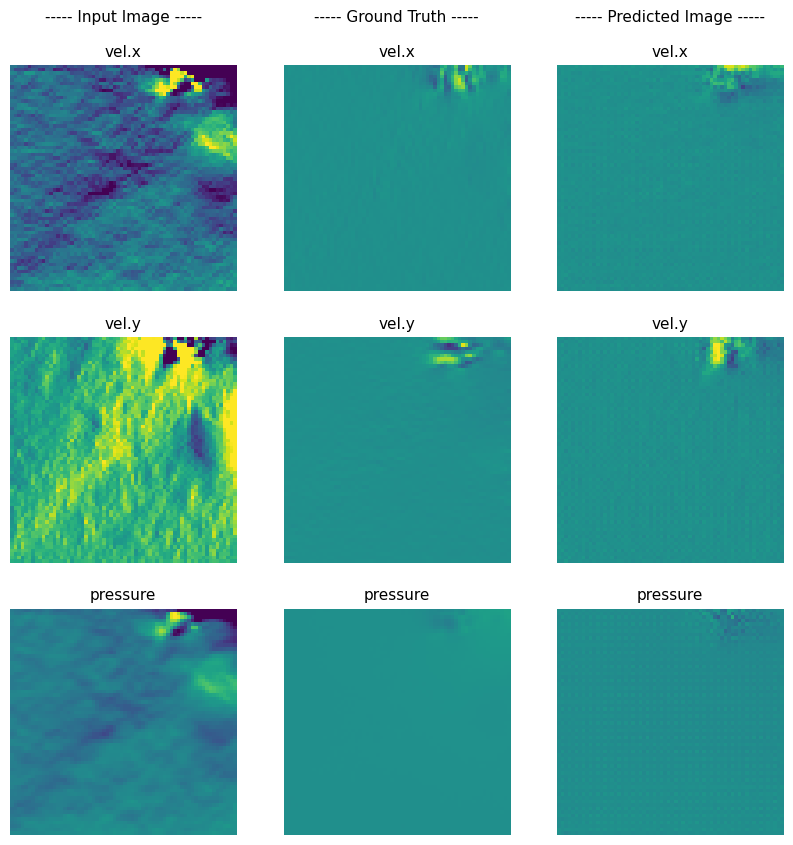

Epoch 230 took 133.67 seconds
Epoch 231, Batch 0:
Generator Loss: 2.6044,  LR: 3.12e-05
Discriminator Loss: 0.0063,  LR: 7.79e-06
Epoch 231, Batch 200:
Generator Loss: 1.8129,  LR: 3.12e-05
Discriminator Loss: 0.1223,  LR: 7.79e-06
Epoch 231, Batch 400:
Generator Loss: 2.5173,  LR: 3.12e-05
Discriminator Loss: 0.0060,  LR: 7.79e-06
Epoch 231, Batch 600:
Generator Loss: 2.3871,  LR: 3.12e-05
Discriminator Loss: 0.0463,  LR: 7.79e-06
Epoch 231 took 123.72 seconds
Epoch 232, Batch 0:
Generator Loss: 1.0636,  LR: 3.12e-05
Discriminator Loss: 0.1309,  LR: 7.79e-06
Epoch 232, Batch 200:
Generator Loss: 1.7615,  LR: 3.12e-05
Discriminator Loss: 0.0044,  LR: 7.79e-06
Epoch 232, Batch 400:
Generator Loss: 1.2854,  LR: 3.12e-05
Discriminator Loss: 0.1332,  LR: 7.79e-06
Epoch 232, Batch 600:
Generator Loss: 1.9717,  LR: 3.12e-05
Discriminator Loss: 0.0059,  LR: 7.79e-06
Epoch 232 took 125.41 seconds
Epoch 233, Batch 0:
Generator Loss: 1.3739,  LR: 3.12e-05
Discriminator Loss: 0.0054,  LR: 7.79e-0

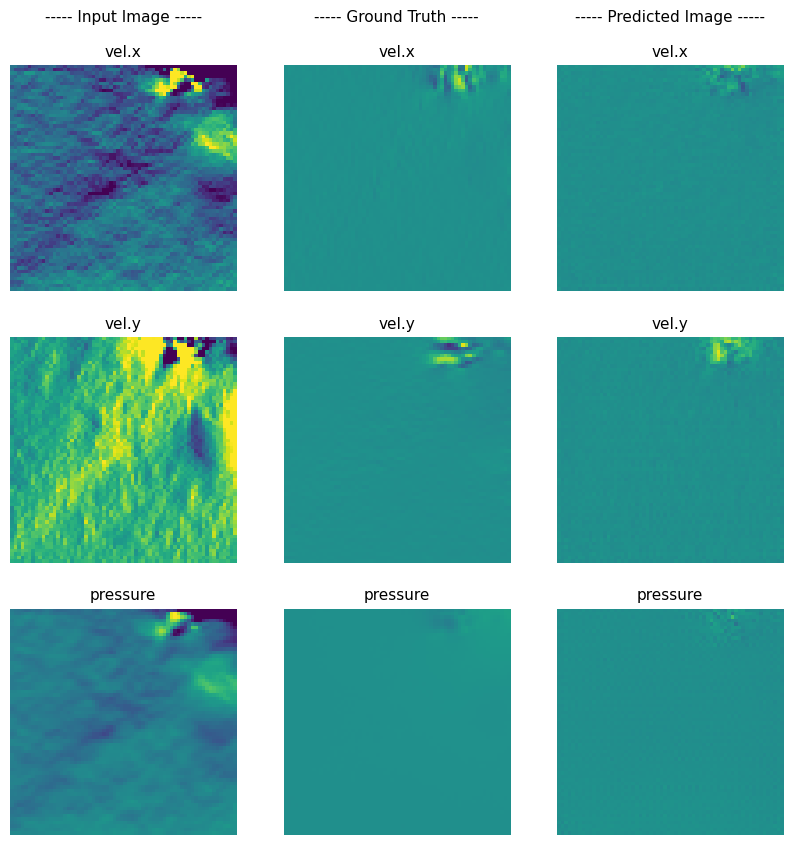

Epoch 235 took 132.90 seconds
Epoch 236, Batch 0:
Generator Loss: 1.1641,  LR: 2.99e-05
Discriminator Loss: 0.1500,  LR: 7.49e-06
Epoch 236, Batch 200:
Generator Loss: 2.2897,  LR: 2.99e-05
Discriminator Loss: 0.0171,  LR: 7.49e-06
Epoch 236, Batch 400:
Generator Loss: 2.3306,  LR: 2.99e-05
Discriminator Loss: 0.0066,  LR: 7.49e-06
Epoch 236, Batch 600:
Generator Loss: 2.4030,  LR: 2.99e-05
Discriminator Loss: 0.0035,  LR: 7.49e-06
Epoch 236 took 130.17 seconds
Epoch 237, Batch 0:
Generator Loss: 2.4480,  LR: 2.99e-05
Discriminator Loss: 0.0053,  LR: 7.49e-06
Epoch 237, Batch 200:
Generator Loss: 1.3099,  LR: 2.99e-05
Discriminator Loss: 0.3501,  LR: 7.49e-06
Epoch 237, Batch 400:
Generator Loss: 2.5353,  LR: 2.99e-05
Discriminator Loss: 0.1003,  LR: 7.49e-06
Epoch 237, Batch 600:
Generator Loss: 0.8173,  LR: 2.99e-05
Discriminator Loss: 0.3061,  LR: 7.49e-06
Epoch 237 took 124.73 seconds
Epoch 238, Batch 0:
Generator Loss: 0.6453,  LR: 2.99e-05
Discriminator Loss: 0.2449,  LR: 7.49e-0

KeyboardInterrupt: 

In [14]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Initialize trainer
trainer = FluidGANTrainer(
    generator=generator,
    discriminator=discriminator,
    train_dataset=train_ds,
    test_dataset=test_ds,
    checkpoint_dir='./training_checkpointsG',
    preview_interval=5,
    checkpoint_interval=20,
    validation_interval=10,
    samples_per_epoch=4000,
    log_rate=200
)

# Start training
trainer.train(epochs=300, batch_size=5)

In [ ]:
import netron
model = "./models/pressure_predict_D_v0.h5"
netron.start(model)